# Audio Event Identification with Teacher-Student Deep Learning

To enhance keyword spotting functionality and the generalization ability on customized keywords for Analog Devices' MAX78000 Chip, a knowledge distillation (Teacher-Student) deep learning framework was implemented with dimensionally reduced pre-trained Wav2Vec2 serving as the teaching model to extract the features of the raw audio. In order to address the integration of an advanced audio recognition system within the limited storage space of the chip, a student model which takes raw audios and learns to mimic the teacher using a simpler Convolutional Neural Network was built. The model structure is shown below: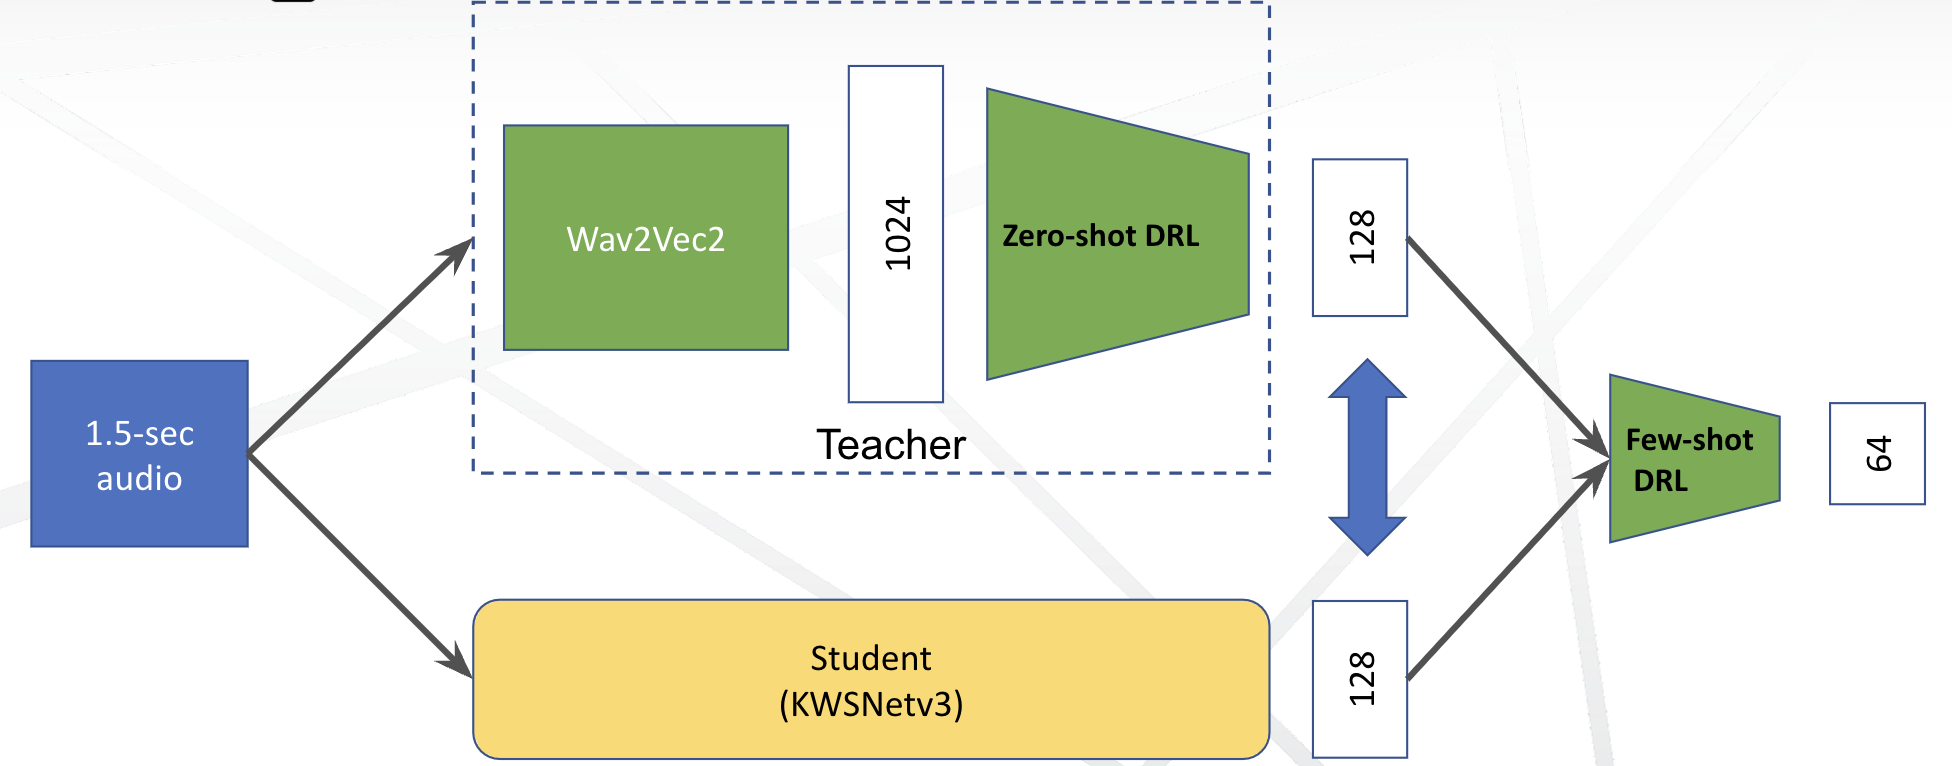

## 0. Import necessary files, libraries

In [ ]:
import numpy as np
import torch
from config import keywords
import ai8x
import random
import matplotlib.pyplot as plt
import itertools
import torch.nn as nn

### 0.1 Define useful functions that I change frequently

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right", va="top")
    plt.yticks(tick_marks, classes)

    plt.xlim(-0.5, len(classes)-0.5) # Add this line to remove white area
    plt.ylim(len(classes)-0.5, -0.5) # Add this line to remove white area

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
class DML2(nn.Module):    #从128降到64？

    def __init__(self):
        super(DML2, self).__init__()
        self.project = nn.Sequential(

            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh()
        )

        self.bias = nn.Parameter(torch.Tensor([0]))
        self.out = nn.Sigmoid()


    def forward_one(self, x):
        x = self.project(x)
        x = x.view(x.size(0), -1)
        return x

    def forward(self, x1, x2):
        out1 = torch.squeeze(self.forward_one(x1))
        out2 = torch.squeeze(self.forward_one(x2))
        out = torch.diag(torch.matmul(out1, out2.T))
        out = self.out(out)# + self.bias)
        return out

In [ ]:
class MaskedXentMarginLoss:    #损失函数
    def __init__(self, zero_weight=1.0, one_weight=1., margin=0.7, eps=1e-7, **kwargs):
        self.margin = margin
        self.zero_weight = zero_weight
        self.one_weight = one_weight
        self.eps = eps

    def __call__(self, pred, labels):
        pred = torch.clamp(pred, min=self.eps, max=1-self.eps)
        loss_mat = -self.one_weight * labels * torch.log(pred) * (pred <= self.margin).float()
        loss_mat -= self.zero_weight * (1 - labels) * torch.log(1-pred) * (pred >= 1 - self.margin).float()
        mask = ((labels == 0) + (labels == 1))
        loss = loss_mat[mask].sum()
        return loss

In [ ]:
def get_batch_no_bck(data, targets, batch_size=32):

    K = len(set(np.squeeze(targets)))
    data_dim = data.shape[1]
    targets = np.asarray(targets)
    anchor = np.zeros((batch_size, data_dim))
    friend = np.zeros((batch_size, data_dim))
    foe = np.zeros((batch_size, data_dim))

    for k in range(batch_size):
        c1, c2 = random.sample(range(K), 2)
        friend_clas_indices = np.where(targets == c1)[0]
        foe_clas_indices = np.where(targets == c2)[0]

        anchor_inx, friend_inx = random.sample(list(friend_clas_indices), 2)
        foe_inx = random.sample(list(foe_clas_indices),1) [0]
        anchor[k, :] = data[anchor_inx]
        friend[k,  :] = data[friend_inx]
        foe[k, :] = data[foe_inx]

    friend_label = np.ones(batch_size)
    foe_label = np.zeros(batch_size)

    batch_1 = torch.from_numpy(np.concatenate((anchor, anchor), axis = 0)).to('cuda:0')
    batch_2 = torch.from_numpy(np.concatenate((friend, foe),  axis = 0)).to('cuda:0')
    label = torch.from_numpy(np.concatenate((friend_label, foe_label))).to('cuda:0')

    return batch_1.float(), batch_2.float(), label

In [ ]:
def calc_acc(classes, test_set, medoids, th=0, return_confmat=False):
    """ when there's no background class use th=0
    th: 阈值，用于判断是否分类错误。当 th 大于0时，如果相似度低于 th，则将样本分为“background”类。"""
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    correct = 0
    incorrect = 0
    data = test_set
    for i in range(len(data)):
        x = data[i,:]
        _max = -10000
        _selection = 0
        for medoid in range(0,4):
            y = medoids[medoid]
            keyword_scores = np.matmul(x, y.T)
            sim = np.mean(keyword_scores, axis=0)
            if sim > _max:
                _selection = medoid
                _max = sim
        if th and _max < th:
            _selection = 4
        confusion_matrix[targets_set[i]][_selection] += 1
        if _selection == targets_set[i]:
            correct +=1
        else:
            incorrect +=1
    acc = correct/(correct+incorrect)
    if return_confmat:
        return acc, confusion_matrix
    else:
        return acc

### 0.2 Load data and the student model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print('Loading test data...')
data_address = '/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/test_features.npz'
data_test = np.load(data_address, allow_pickle=True)
test_features = data_test.f.test_features.item()
PATH = '/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/models/KWSNetv4.pt'
model = torch.load(PATH)
model.cuda()
act_mode_8bit = False
avg_pool_rounding = True
ai8x.set_device(85, act_mode_8bit, avg_pool_rounding)

Loading test data...
Configuring device: MAX78000, simulate=False.


In [ ]:
test_features

{'hey_snapdragon': {'raw': array([[[-2.74658203e-03, -2.74658203e-03, -2.44140625e-03, ...,
            9.15527344e-04,  1.22070312e-03,  9.15527344e-04],
          [ 6.10351562e-04,  9.15527344e-04,  1.22070312e-03, ...,
           -1.83105469e-03, -2.13623047e-03, -1.52587891e-03],
          [-1.52587891e-03, -1.83105469e-03, -1.22070312e-03, ...,
           -3.35693359e-03, -3.35693359e-03, -3.66210938e-03],
          ...,
          [-7.78212322e-02,  5.61771813e-03, -6.68531108e-03, ...,
           -1.36218491e-01, -6.25828343e-02,  1.91674503e-02],
          [-9.38568174e-02, -8.00841094e-03,  2.00472309e-01, ...,
            3.14324710e-02,  8.31476302e-02,  3.95331400e-02],
          [-6.63290701e-02,  8.87038111e-02, -1.16275667e-01, ...,
            3.06588482e-02,  1.72282057e-01, -2.30726988e-01]],
  
         [[ 9.15527344e-04,  0.00000000e+00,  6.10351562e-04, ...,
           -6.10351562e-04, -1.52587891e-03, -9.15527344e-04],
          [-6.10351562e-04, -1.22070312e-03, -

In [ ]:
test_features.keys()

dict_keys(['hey_snapdragon', 'hi_galaxy', 'hey_android', 'hi_lumina', 'background'])

In [ ]:
test_features['hey_snapdragon'].keys()

dict_keys(['raw', 'wav2vec2'])

In [ ]:
test_features['hey_snapdragon']['raw'].shape

(1112, 192, 128)

In [ ]:
test_features['hey_snapdragon']['wav2vec2'].shape

(1112, 1024)

In [ ]:
test_features['background']['raw'].shape

(12627, 192, 128)

In [ ]:
train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/hi_galaxy_train_test_split.npz'
data = np.load(train_test_split_address, allow_pickle=True)
data
#training_indexes = data.f.training_indexes

In [ ]:
keys = data.files
print(keys)

['training_indexes', 'test_indexes']


In [ ]:
test = data.f.test_indexes

In [ ]:
test

array([  0,   1,   3,   4,   5,   6,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  35,  36,  37,  38,  40,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 190, 19

In [ ]:
len(test)

885

## 1. Make a dataset for classification WITHOUT background

In [ ]:
medoids = []
data_shape = 128
test_set = np.empty((0, data_shape))    #数组的行数为0，所以初始时该数组为空
targets_set = np.empty((0,), dtype=int)    #1D数组，初始时没有任何元素。创建一个空数组通常用于预先分配内存以后进行填充，这在需要动态构建数组的情况下非常有用。
keywords = ['hey_snapdragon',
 'hi_galaxy',
 'hey_android',
 'hi_lumina']
for label, keyword in enumerate(keywords):
    keyword_waveform = test_features[keyword]['raw']
    emb_kwrd = model(torch.from_numpy(keyword_waveform).float().cuda().permute(0, 2, 1)).detach().cpu().numpy()    #KWSNetv4.pt
    train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
    data = np.load(train_test_split_address, allow_pickle=True)
    training_indexes = data.f.training_indexes    #50 samples
    test_indexes = data.f.test_indexes
    train_samples = emb_kwrd[training_indexes]
    test_samples = emb_kwrd[test_indexes]
    targets = label*np.ones((test_samples.shape[0],), dtype=int)
    test_set = np.concatenate((test_set, test_samples), axis=0)    #按行合并数组
    targets_set = np.concatenate((targets_set, targets), axis=0)
    medoids.append(train_samples)    #只跟train有关，test只创建了数据集和其对应的标签但是还没用

    print(keyword)
    print(train_samples)

medoids

hey_snapdragon
[[ 0.20102839  0.03163162  0.00095519 ... -0.01299668  0.15566553
   0.07824253]
 [ 0.16013724  0.10840327 -0.04082587 ... -0.06184001  0.15811665
   0.00236623]
 [ 0.12698583  0.04831429  0.0332763  ... -0.05582791 -0.01064096
   0.11082854]
 ...
 [ 0.0979788   0.06937635 -0.01356759 ...  0.0864565  -0.00527605
   0.28531748]
 [ 0.01346468  0.07355049 -0.1600478  ...  0.016275    0.07003786
  -0.01144489]
 [ 0.00236727 -0.11323292 -0.01212503 ...  0.04594359  0.2369021
  -0.04033606]]
hi_galaxy
[[ 0.10142155  0.07657187 -0.05019491 ... -0.21531755  0.1602188
  -0.09448751]
 [ 0.08304498 -0.02658695 -0.06128854 ... -0.21640581  0.04120885
   0.03148232]
 [-0.08406144 -0.19151226  0.01339381 ...  0.06516883  0.16352704
  -0.03735563]
 ...
 [ 0.11882552 -0.36746702 -0.11596463 ... -0.02856568  0.19951105
  -0.07600038]
 [ 0.14532068  0.02577349 -0.02003418 ... -0.04308911  0.14511001
  -0.01899671]
 [-0.04315149  0.01710468 -0.0968403  ...  0.11971443  0.3129246
  -0.08246

[array([[ 0.20102839,  0.03163162,  0.00095519, ..., -0.01299668,
          0.15566553,  0.07824253],
        [ 0.16013724,  0.10840327, -0.04082587, ..., -0.06184001,
          0.15811665,  0.00236623],
        [ 0.12698583,  0.04831429,  0.0332763 , ..., -0.05582791,
         -0.01064096,  0.11082854],
        ...,
        [ 0.0979788 ,  0.06937635, -0.01356759, ...,  0.0864565 ,
         -0.00527605,  0.28531748],
        [ 0.01346468,  0.07355049, -0.1600478 , ...,  0.016275  ,
          0.07003786, -0.01144489],
        [ 0.00236727, -0.11323292, -0.01212503, ...,  0.04594359,
          0.2369021 , -0.04033606]], dtype=float32),
 array([[ 0.10142155,  0.07657187, -0.05019491, ..., -0.21531755,
          0.1602188 , -0.09448751],
        [ 0.08304498, -0.02658695, -0.06128854, ..., -0.21640581,
          0.04120885,  0.03148232],
        [-0.08406144, -0.19151226,  0.01339381, ...,  0.06516883,
          0.16352704, -0.03735563],
        ...,
        [ 0.11882552, -0.36746702, -0.1

## 2. Observe classification accuracy and the 3M matrix

### 2.1 Accuracy and confusion matrix

0.7666257668711657
Confusion matrix, without normalization
[[765 251  39   8]
 [  7 868   2   8]
 [114 205 703  42]
 [ 24  86 165 788]]


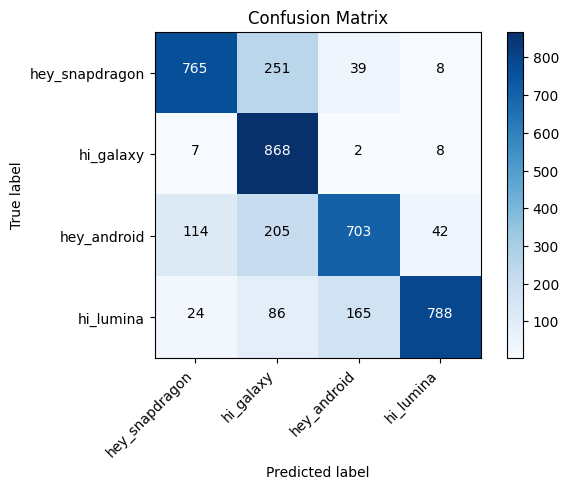

In [ ]:
classes = set(np.squeeze(targets_set))
acc, conf_mat = calc_acc(classes, test_set, medoids, th=0, return_confmat=True)
print(acc)
plot_confusion_matrix(conf_mat, keywords)


### 2.2 3M Matrices (min, mean, max)

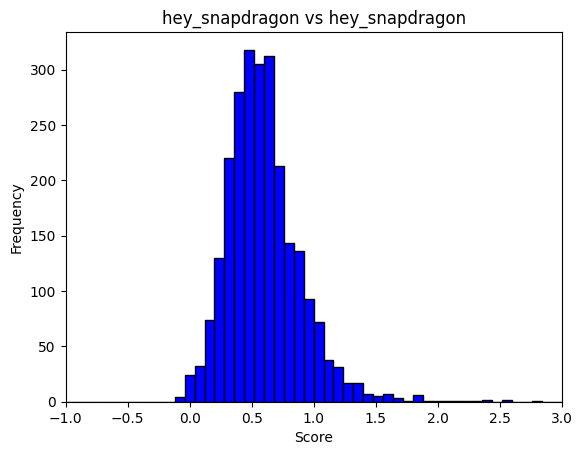

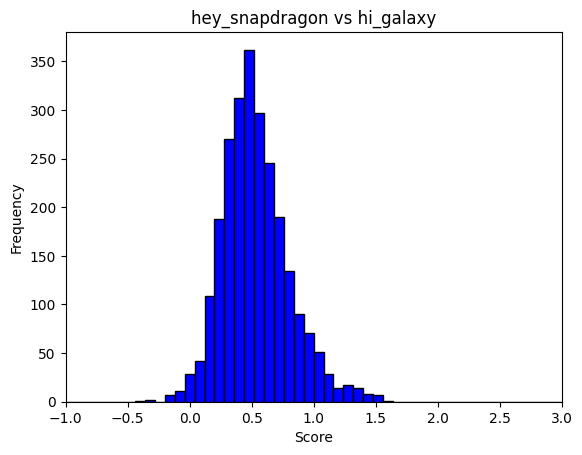

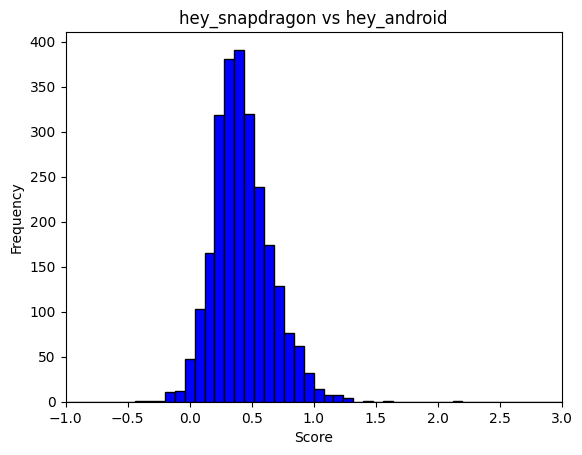

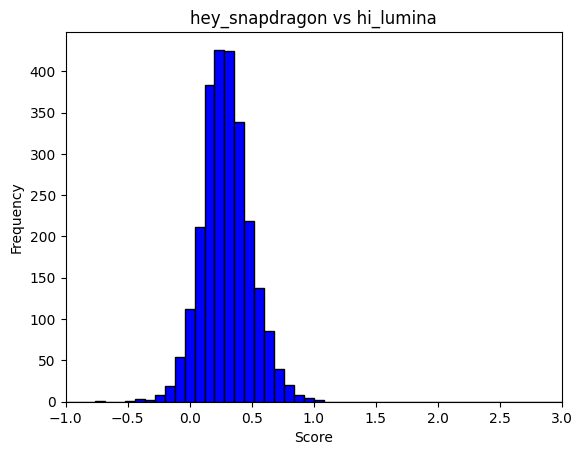

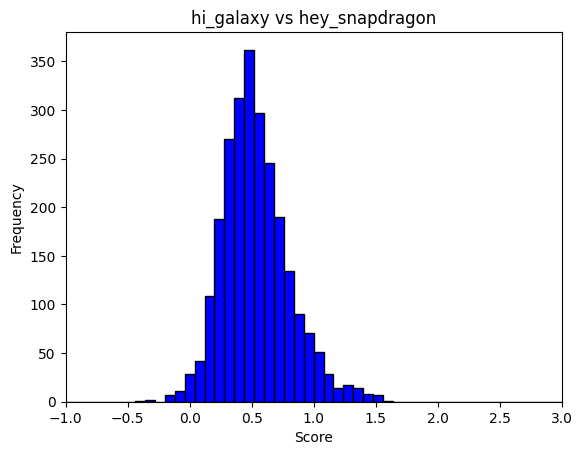

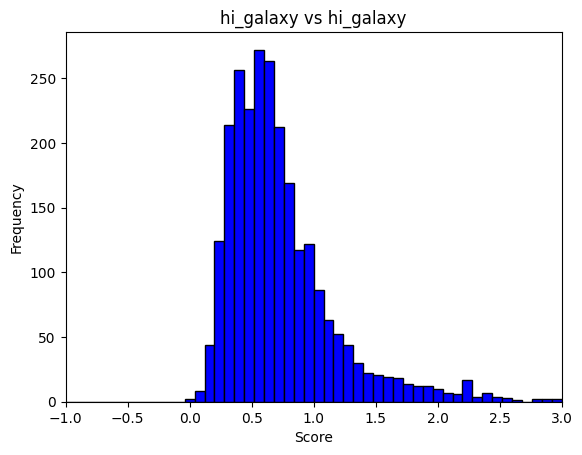

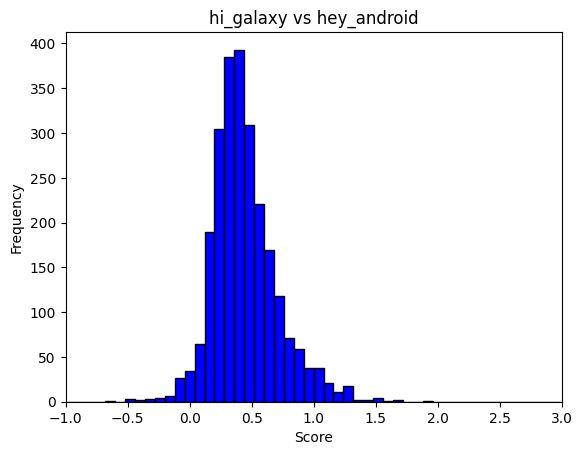

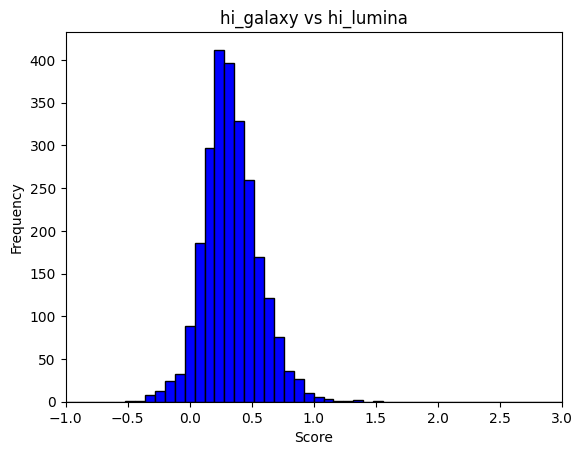

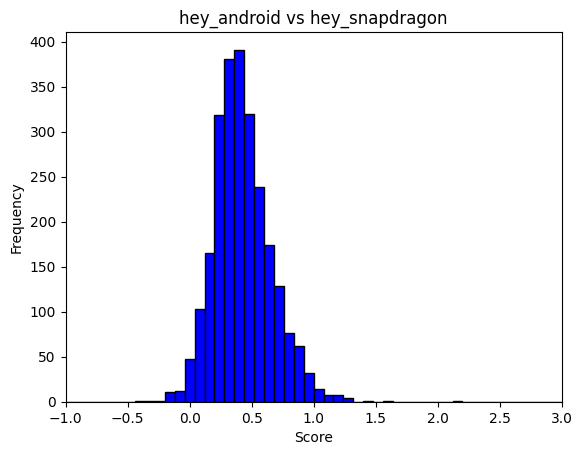

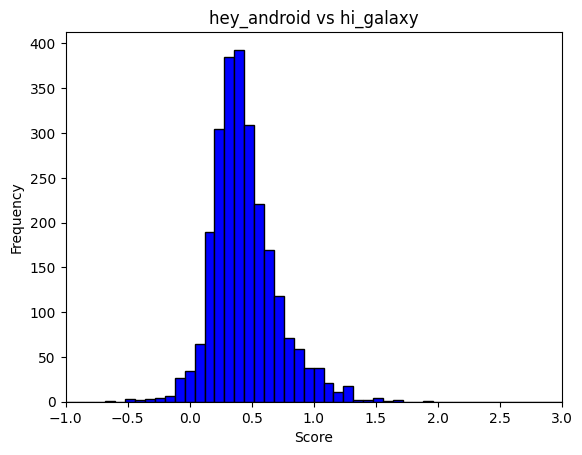

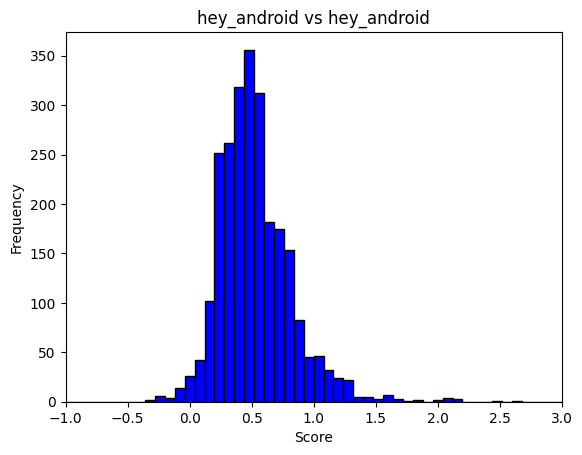

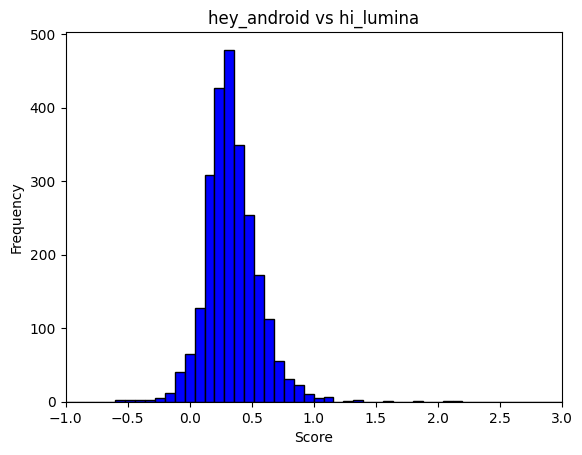

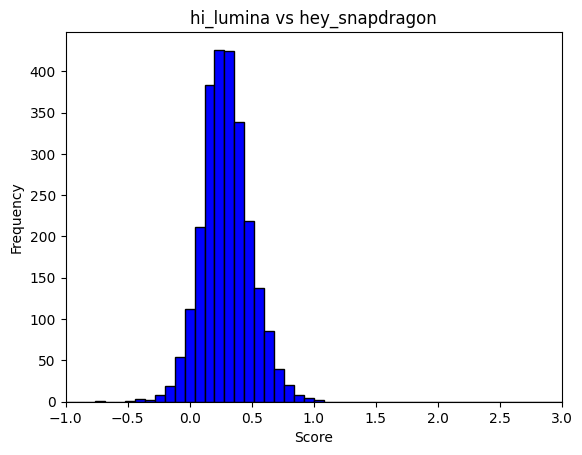

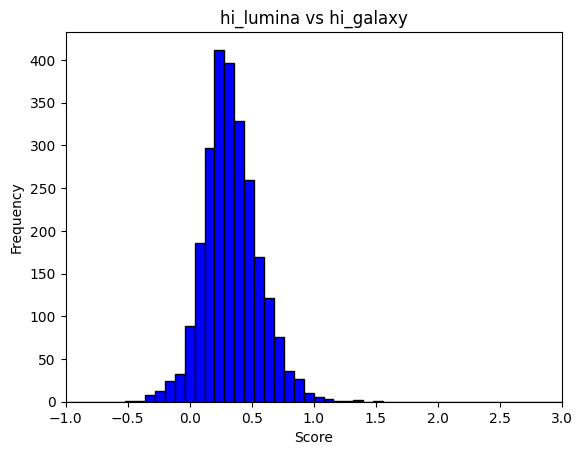

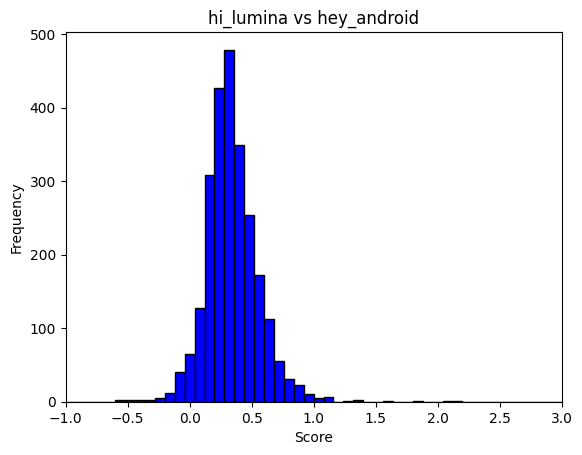

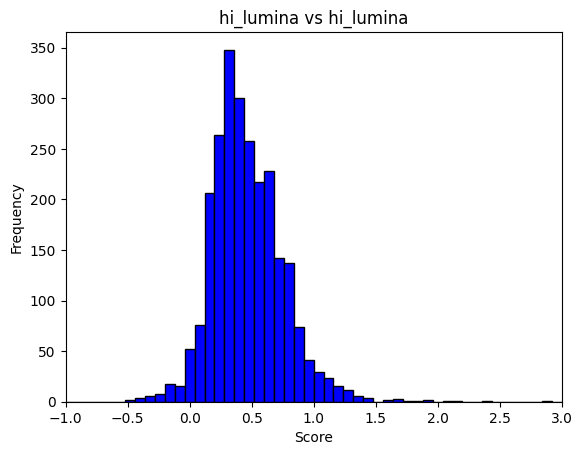

[[-0.10174935 -0.36037892 -0.40525281 -0.6985541 ]
 [-0.36037892  0.00824592 -0.65473408 -0.48183414]
 [-0.40525281 -0.6547339  -0.29155841 -0.58323073]
 [-0.69855392 -0.48183414 -0.58323073 -0.48668256]]
[[3.43074274 1.61604524 2.14560366 1.0743494 ]
 [1.61604548 4.82558203 1.90030122 1.4867661 ]
 [2.14560366 1.90030086 4.06748056 2.1984036 ]
 [1.07434988 1.4867661  2.1984036  2.90167236]]
[[0.60047102 0.53106624 0.42575532 0.29416814]
 [0.53106624 0.74265587 0.44369844 0.33378646]
 [0.42575532 0.44369844 0.53456503 0.34058681]
 [0.29416817 0.33378646 0.34058684 0.46438944]]


In [ ]:
mins = np.zeros((4,4))
maxes = np.zeros((4,4))
means = np.zeros((4,4))
for kw1 in range(0,4):
    for kw2 in range(0,4):
        keyword1, keyword2 = keywords[kw1],  keywords[kw2]
        medoid1, medoid2 = medoids[kw1], medoids[kw2]
        keyword_scores = np.matmul(medoid1, medoid2.T)    #矩阵相乘，用于计算两个嵌入向量的相似度分数
        mins[kw1, kw2] = keyword_scores.min()
        maxes[kw1, kw2] = keyword_scores.max()
        means[kw1, kw2] = keyword_scores.mean()
        plt.hist(keyword_scores.flatten(), bins=50, range=(-1, 3), color='blue', edgecolor='black')

        plt.title(f'{keyword1} vs {keyword2}')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.xlim(-1, 3)
        plt.show()


print(mins)
print(maxes)
print(means)

## 3. Make dataset for training DML WITHOUT background and Train DML

In [ ]:
training_set = np.vstack(medoids)
training_labels = np.vstack([[i]*medoids[i].shape[0] for i in range(4)]).flatten()
print(training_set.shape)

(200, 128)


0.56
[[157 445 437  24]
 [  2 791  68  24]
 [  1 204 817  42]
 [  1 217 328 517]]
0.8485889570552148
[[ 896   70   81   16]
 [  32  804    6   43]
 [ 111   30  728  195]
 [   1    7   25 1030]]
0.9047852760736196
[[ 971   35   48    9]
 [  13  842   10   20]
 [  58   56  857   93]
 [   1    7   38 1017]]
0.9150920245398773
[[ 975   33   43   12]
 [   6  850    4   25]
 [  37   54  885   88]
 [   1   11   32 1019]]
0.914601226993865
[[ 998   23   32   10]
 [   9  843    5   28]
 [  35   56  868  105]
 [   2    6   37 1018]]
0.9141104294478528
[[ 997   28   32    6]
 [  11  848    3   23]
 [  39   65  869   91]
 [   3   12   37 1011]]
0.914601226993865
[[ 989   26   37   11]
 [  10  848    3   24]
 [  34   61  877   92]
 [   1   12   37 1013]]
0.9150920245398773
[[ 989   28   38    8]
 [   9  847    5   24]
 [  28   66  878   92]
 [   1   13   34 1015]]
0.9150920245398773
[[ 997   26   32    8]
 [  10  847    4   24]
 [  45   59  874   86]
 [   1   11   40 1011]]
0.9123926380368098
[[ 98

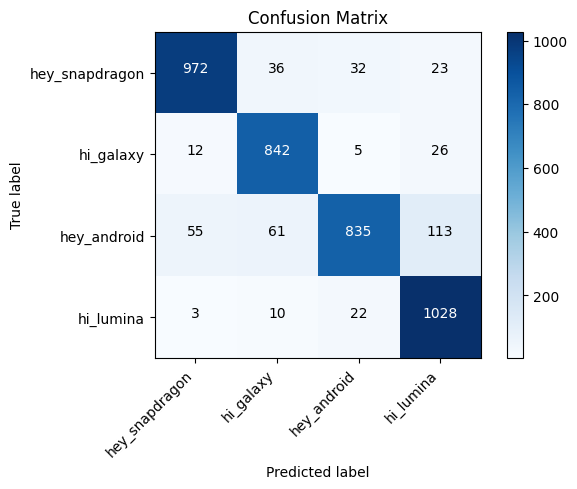

In [ ]:
device = 'cuda:0'
lr = 0.0003
margin = 0.9
batch_size = 32
model.to(device)
sigma2 = DML2()
sigma2.float().to(device).train()
optimizer = torch.optim.Adam(sigma2.parameters(), lr=lr)
optimizer.zero_grad()
data_shape = 64
loss_fn = MaskedXentMarginLoss(margin=margin)
for i in range(5000):
    anchor, alien, labels = get_batch_no_bck(training_set, training_labels, batch_size=batch_size)
    optimizer.zero_grad()
    output = sigma2.forward(anchor, alien)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

    if not i%200:
        medoids = []
        test_set = np.empty((0, data_shape))
        targets_set = np.empty((0,), dtype=int)
        keywords = ['hey_snapdragon',
         'hi_galaxy',
         'hey_android',
         'hi_lumina']
        for label, keyword in enumerate(keywords):
            keyword_waveform = test_features[keyword]['raw']
            emb_kwrd = model(torch.from_numpy(keyword_waveform).float().to(device).permute(0, 2, 1))
            emb_kwrd = sigma2.forward_one(emb_kwrd).detach().cpu().numpy()
            train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
            data = np.load(train_test_split_address, allow_pickle=True)
            training_indexes = data.f.training_indexes
            test_indexes = data.f.test_indexes
            train_samples = emb_kwrd[training_indexes]
            test_samples = emb_kwrd[test_indexes]
            targets = label*np.ones((test_samples.shape[0],), dtype=int)
            test_set = np.concatenate((test_set, test_samples), axis=0)
            targets_set = np.concatenate((targets_set, targets), axis=0)
            medoids.append(train_samples)
        classes = set(np.squeeze(targets_set))
        res, confusion_matrix = calc_acc(classes, test_set, medoids, th=0, return_confmat=True)
        print(res)
        print(confusion_matrix)

plot_confusion_matrix(confusion_matrix, keywords)

## 4. observe 3M after DML, save model

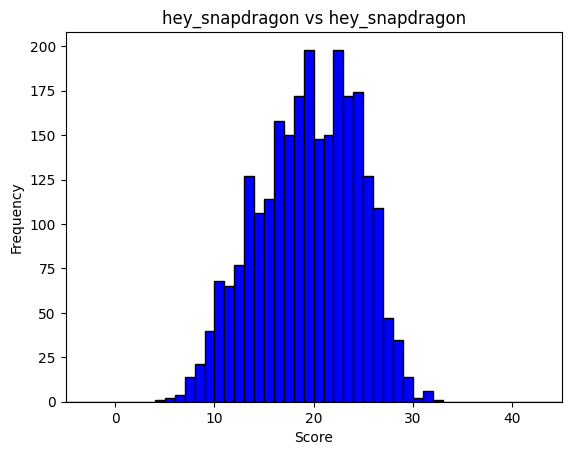

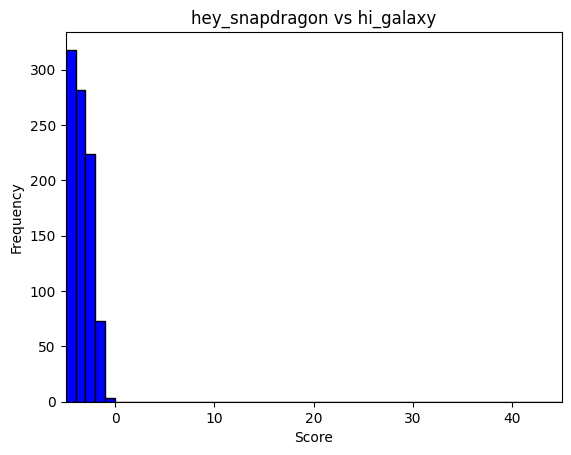

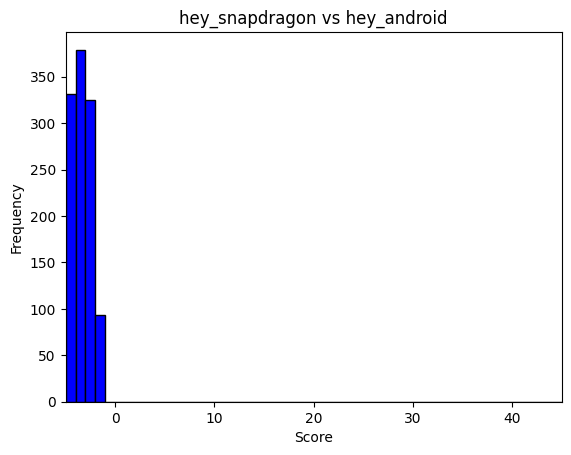

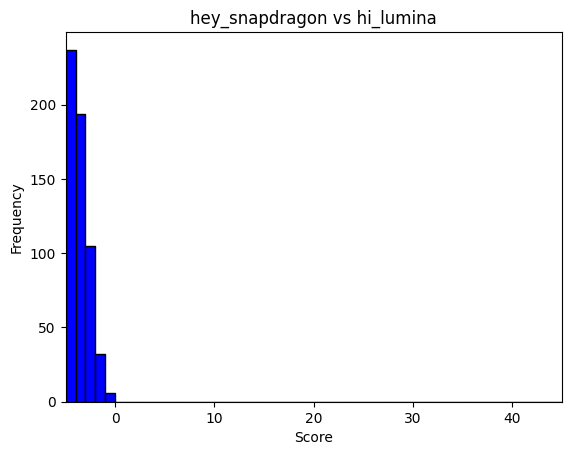

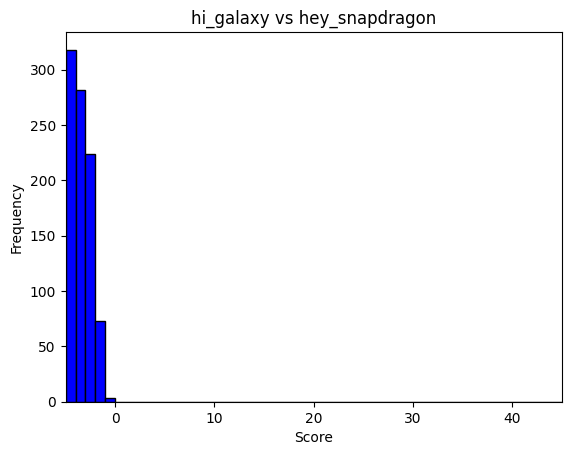

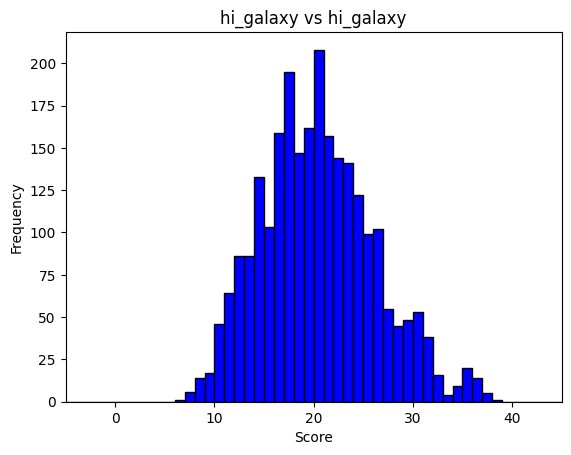

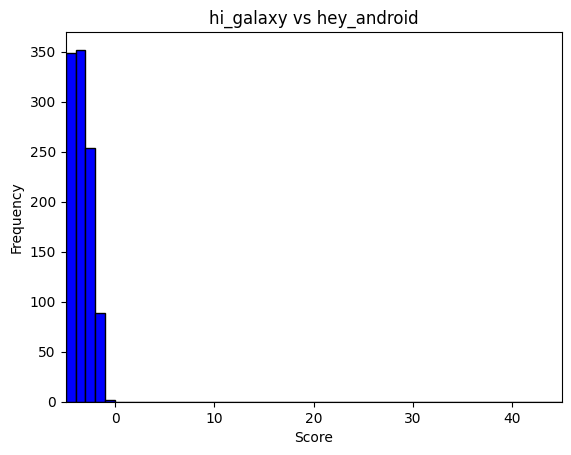

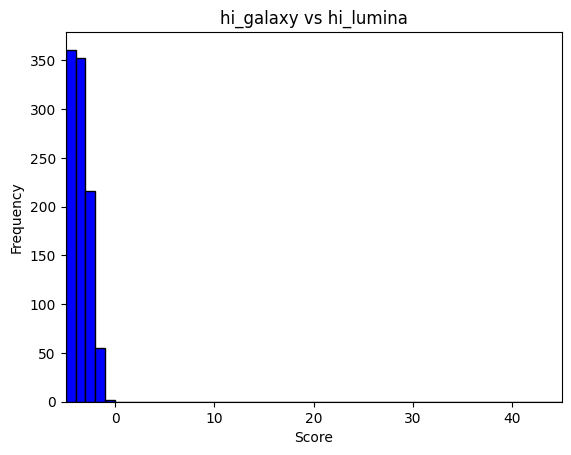

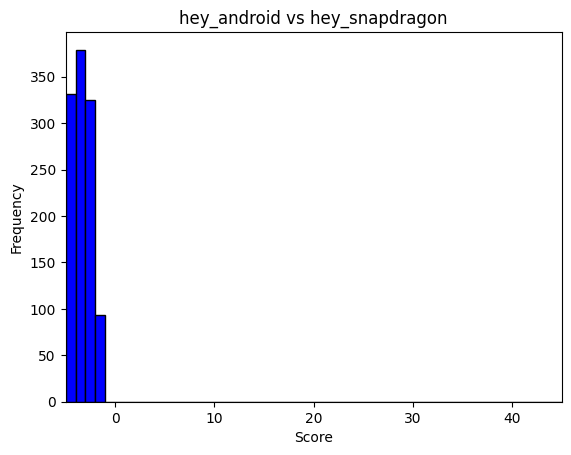

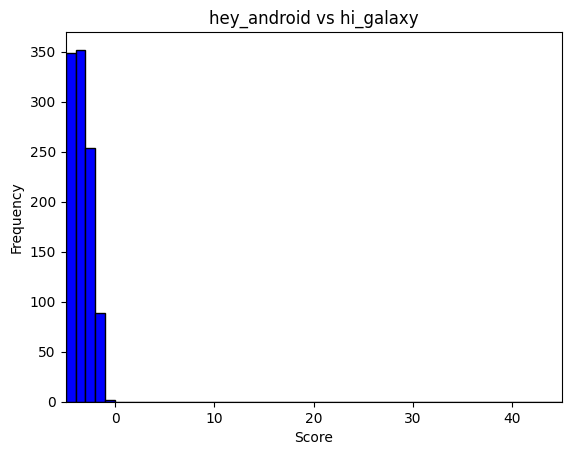

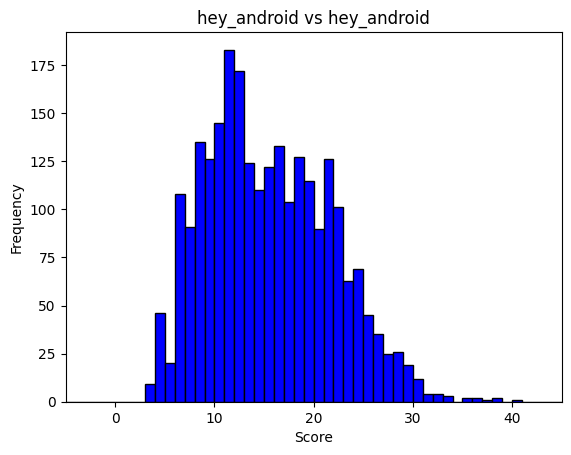

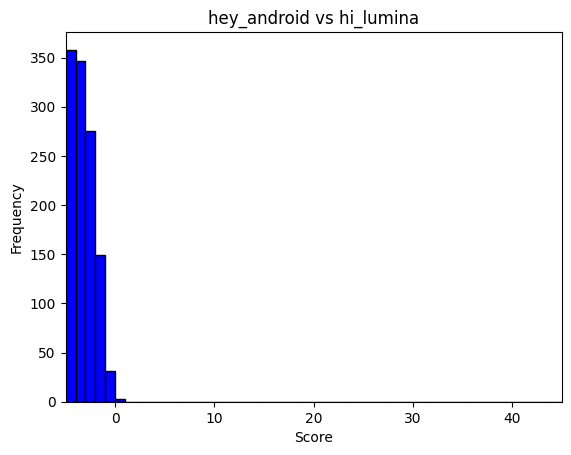

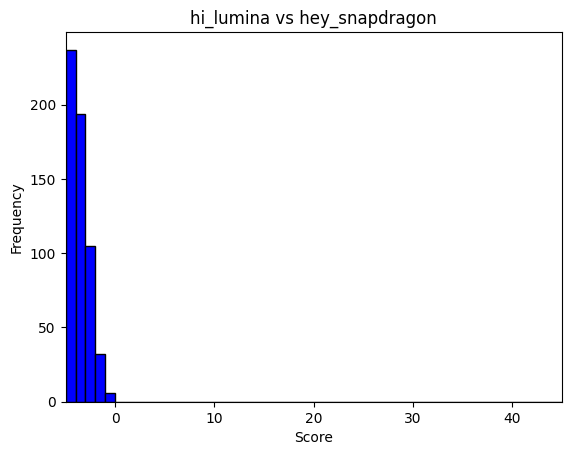

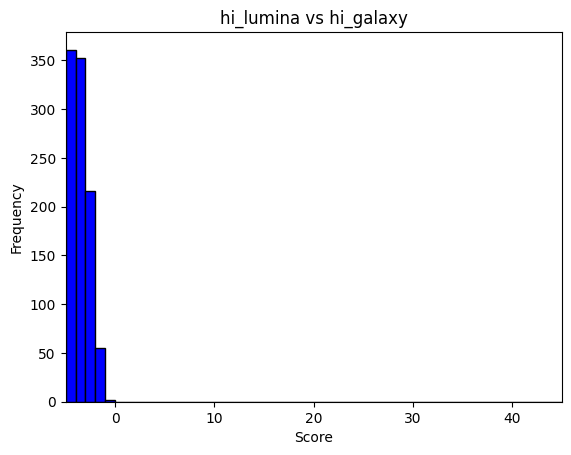

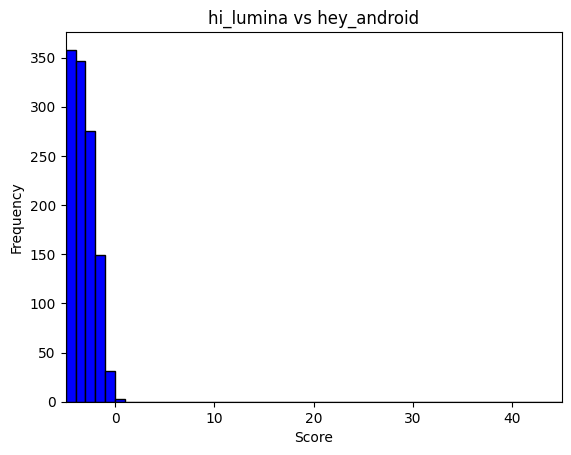

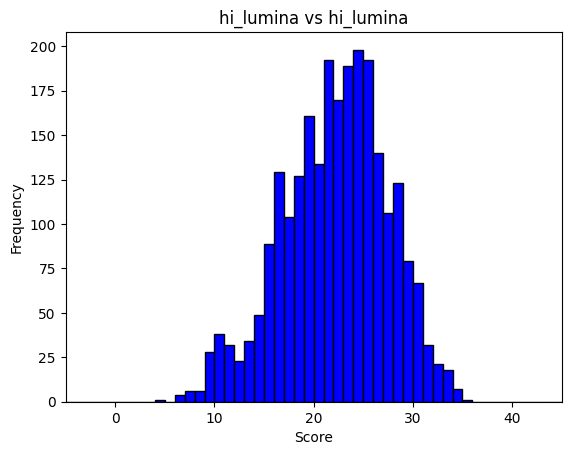

[[  4.96147346 -18.99660301 -20.57083702 -19.38385582]
 [-18.99660492   6.81624508 -17.51513863 -16.3661747 ]
 [-20.57083702 -17.51514244   3.29413891 -15.52992344]
 [-19.38385582 -16.3661747  -15.52992344   4.67154169]]
[[32.48765945 -0.76638782 -1.01811016 -0.08397271]
 [-0.76638782 38.70681763 -0.56823707 -0.40250531]
 [-1.01810992 -0.56823677 40.57045364  0.51760018]
 [-0.08397271 -0.40250531  0.51760018 35.58890915]]
[[19.40992737 -6.65666103 -5.99042511 -7.50348997]
 [-6.65666103 20.43494606 -6.10876846 -6.38803911]
 [-5.99042511 -6.10876894 15.48647022 -5.74162245]
 [-7.50348902 -6.38803911 -5.74162245 22.15327644]]


In [ ]:
mins = np.zeros((4,4))
maxes = np.zeros((4,4))
means = np.zeros((4,4))
for kw1 in range(0,4):
    for kw2 in range(0,4):
        keyword1, keyword2 = keywords[kw1],  keywords[kw2]
        medoid1, medoid2 = medoids[kw1], medoids[kw2]
        keyword_scores = np.matmul(medoid1, medoid2.T)
        mins[kw1, kw2] = keyword_scores.min()
        maxes[kw1, kw2] = keyword_scores.max()
        means[kw1, kw2] = keyword_scores.mean()
        plt.hist(keyword_scores.flatten(), bins=50, range=(-5, 45), color='blue', edgecolor='black')

        plt.title(f'{keyword1} vs {keyword2}')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.xlim(-5, 45)
        plt.show()


print(mins)
print(maxes)
print(means)

## 5. Make a classification dataset with the background

In [ ]:
model.cuda()
medoids = []
data_shape = 128
test_set = np.empty((0, data_shape))
targets_set = np.empty((0,), dtype=int)
keywords = ['hey_snapdragon',
 'hi_galaxy',
 'hey_android',
 'hi_lumina']

for label, keyword in enumerate(keywords):
    keyword_waveform = test_features[keyword]['raw']
    emb_kwrd = model(torch.from_numpy(keyword_waveform).float().cuda().permute(0, 2, 1)).detach().cpu().numpy()
    train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
    data = np.load(train_test_split_address, allow_pickle=True)
    training_indexes = data.f.training_indexes
    test_indexes = data.f.test_indexes
    train_samples = emb_kwrd[training_indexes]
    test_samples = emb_kwrd[test_indexes]
    targets = label*np.ones((test_samples.shape[0],), dtype=int)
    test_set = np.concatenate((test_set, test_samples), axis=0)
    targets_set = np.concatenate((targets_set, targets), axis=0)
    medoids.append(train_samples)

#下面是照步骤1多的部分
background_waveform = test_features['background']['raw']
emb_bck = model(torch.from_numpy(background_waveform).float().cuda().permute(0, 2, 1)).detach().cpu().numpy()
train_samples = emb_bck[:10000]
test_samples = emb_bck[10000:]
targets = 4*np.ones((test_samples.shape[0],), dtype=int)
test_set = np.concatenate((test_set, test_samples), axis=0)
targets_set = np.concatenate((targets_set, targets), axis=0)
medoids.append(train_samples)

## 6. Observe 3M, class-background distributions and determine threshold

0.622202327663384
Confusion matrix, without normalization
[[ 586  189   14    1  273]
 [   2  719    1    3  160]
 [  63  139  400   12  450]
 [   8   31   29  353  642]
 [ 245  235   18   17 2112]]


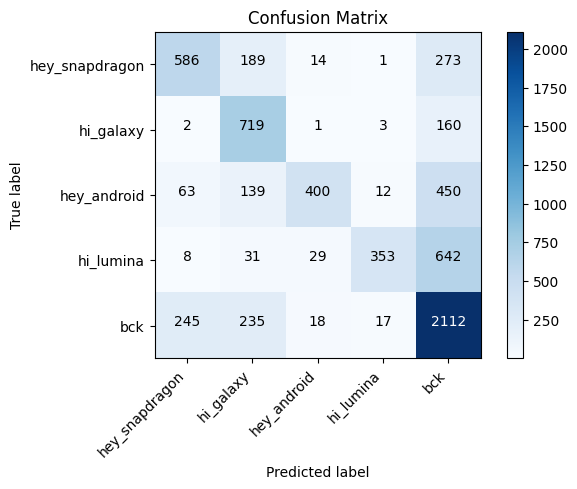

In [ ]:
classes = set(np.squeeze(targets_set))
acc, conf_mat = calc_acc(classes, test_set, medoids, th=0.5, return_confmat=True)
print(acc)
keywords.append('bck')
plot_confusion_matrix(conf_mat,keywords)

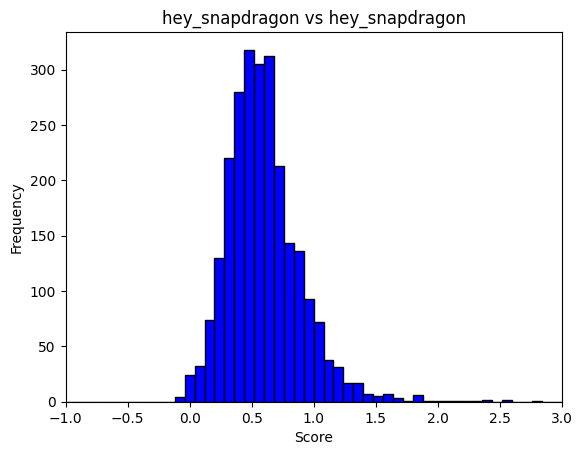

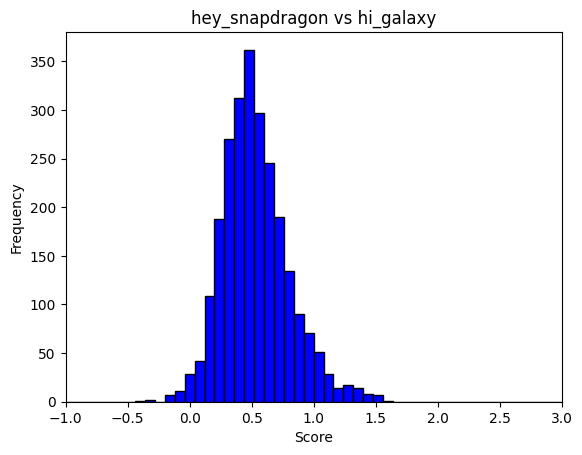

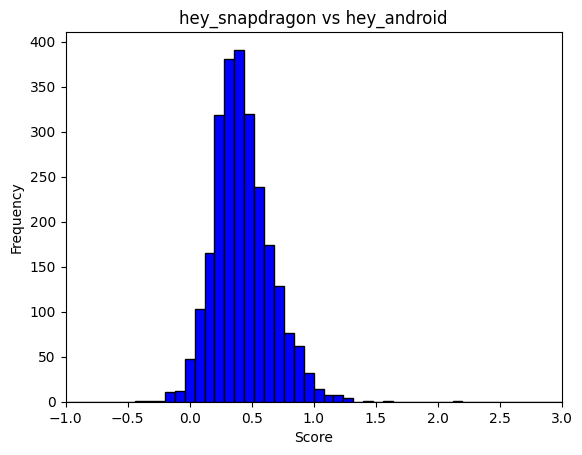

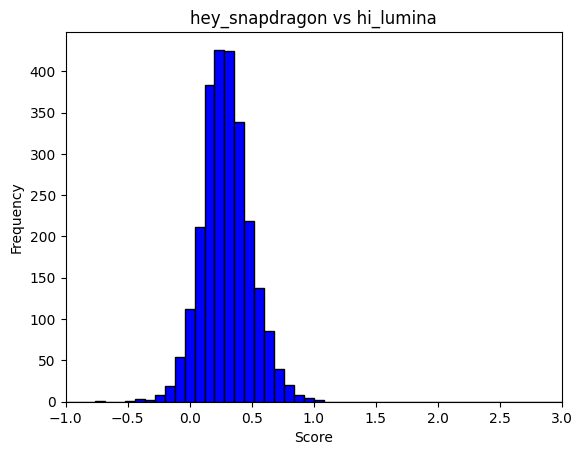

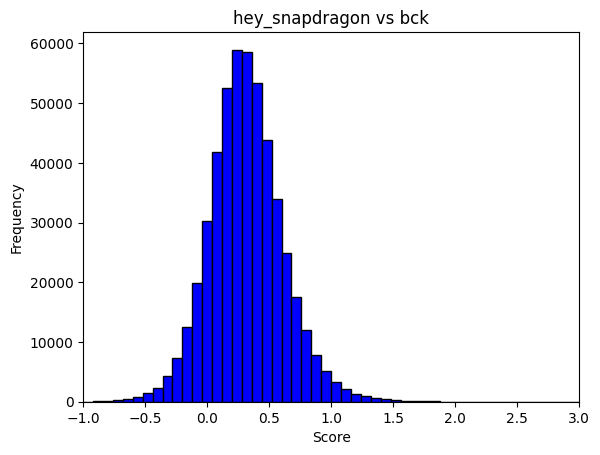

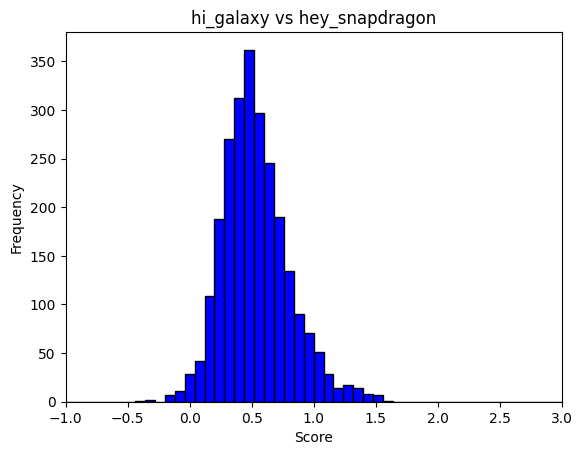

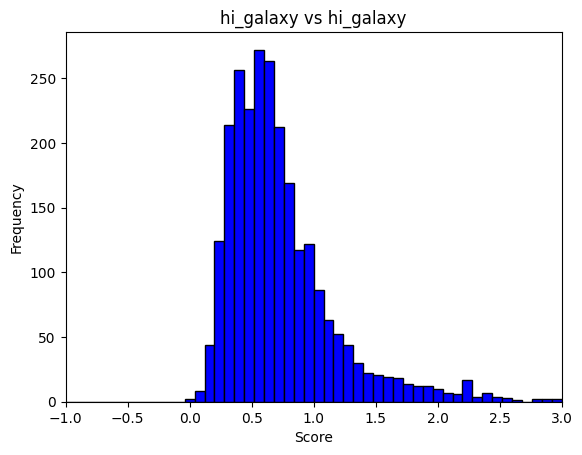

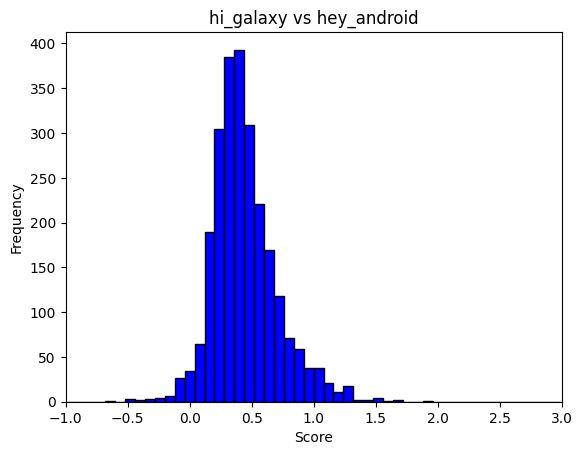

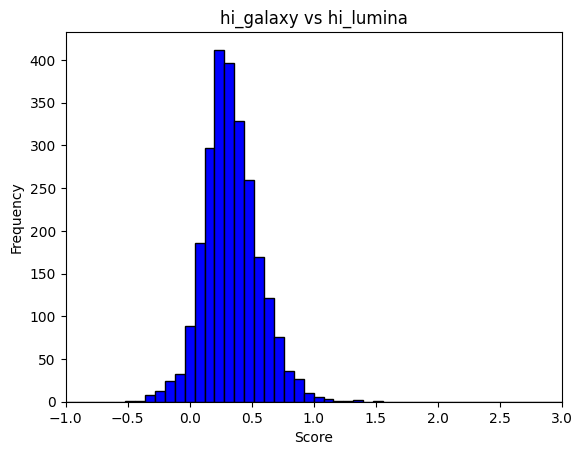

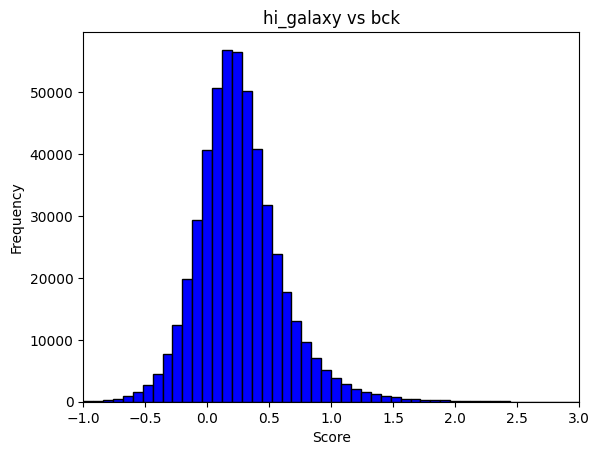

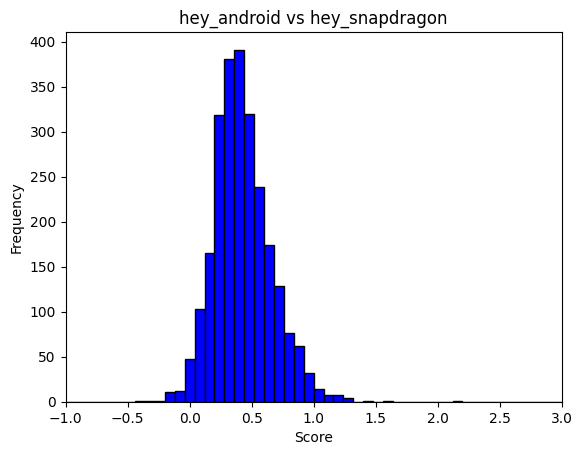

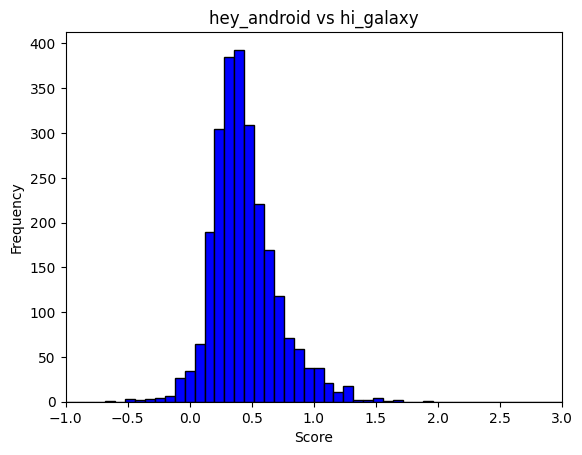

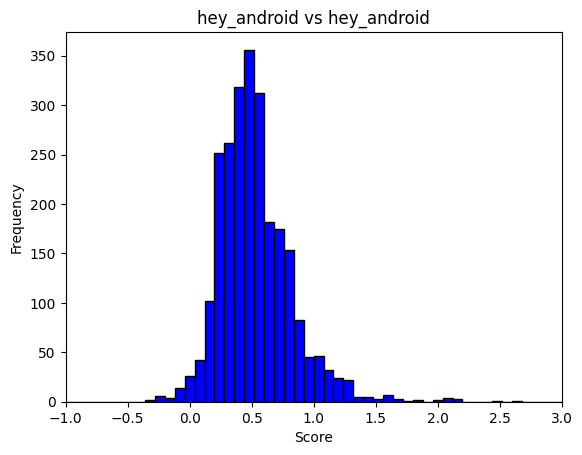

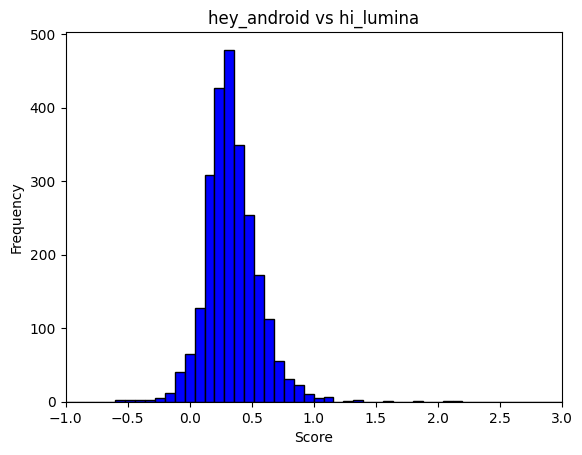

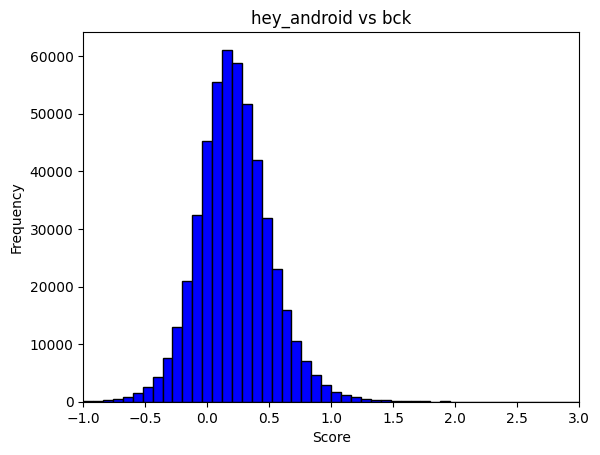

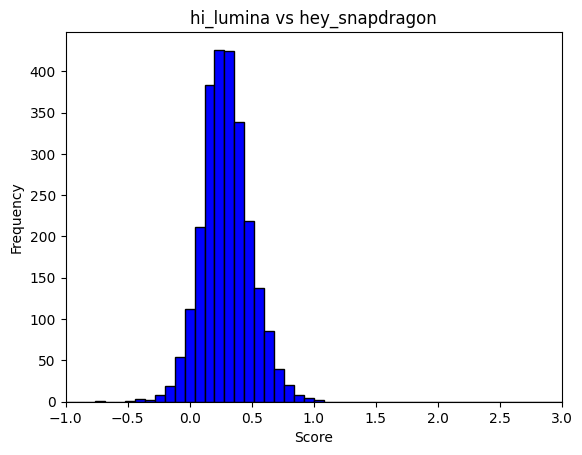

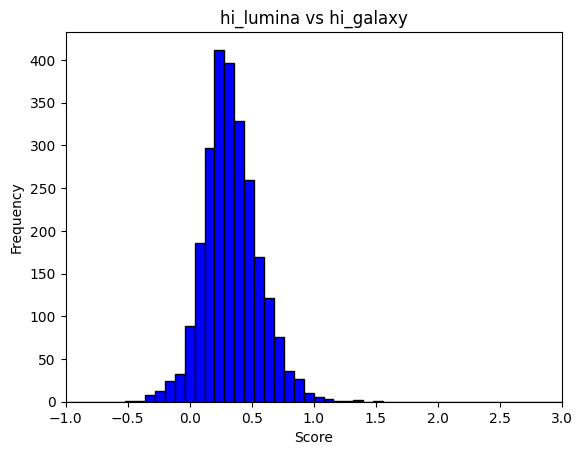

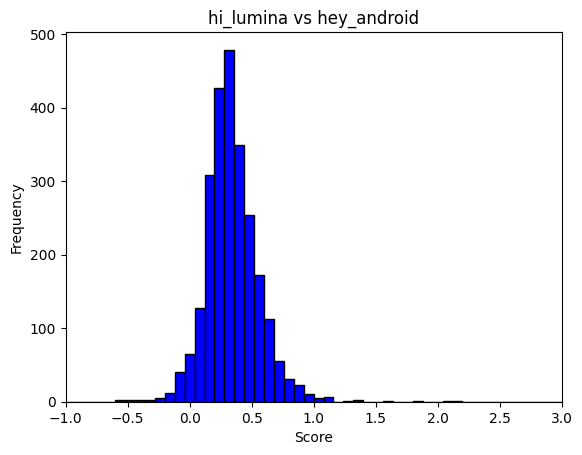

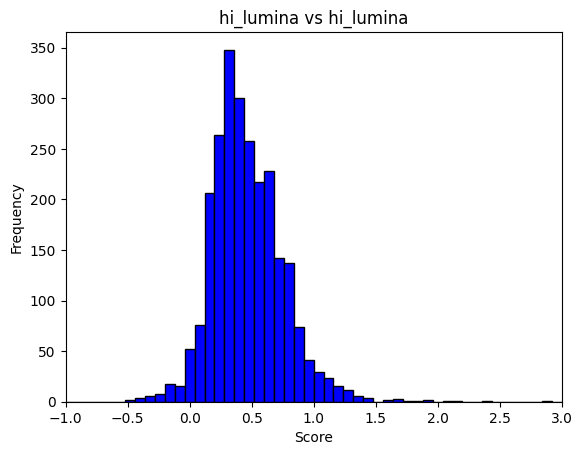

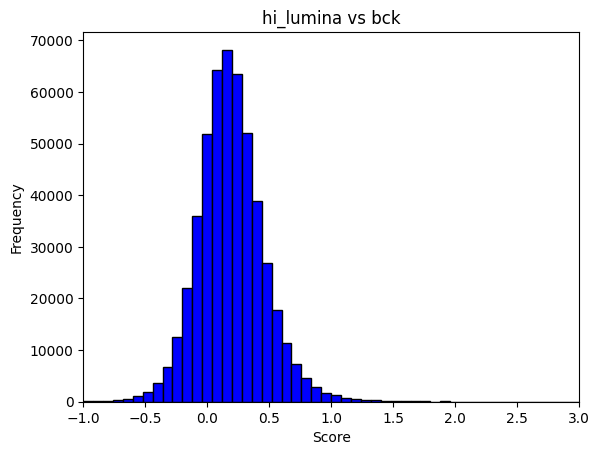

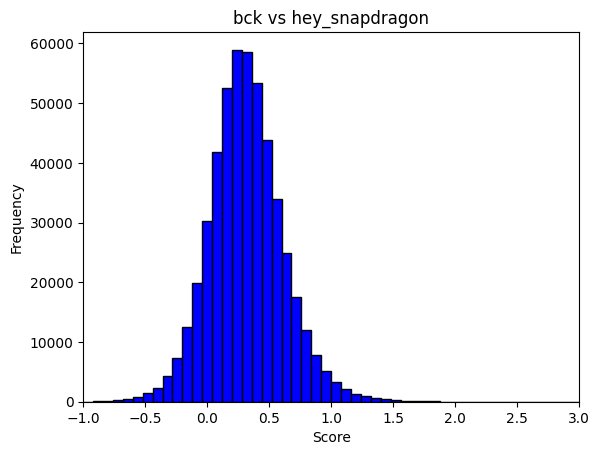

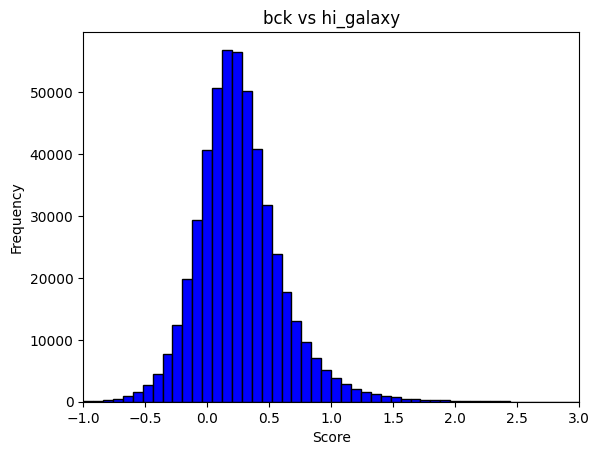

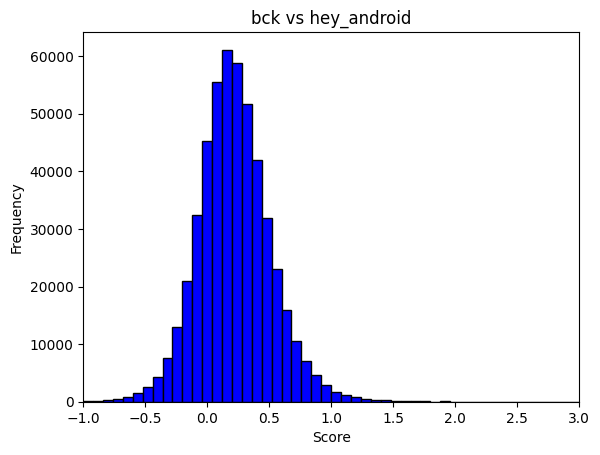

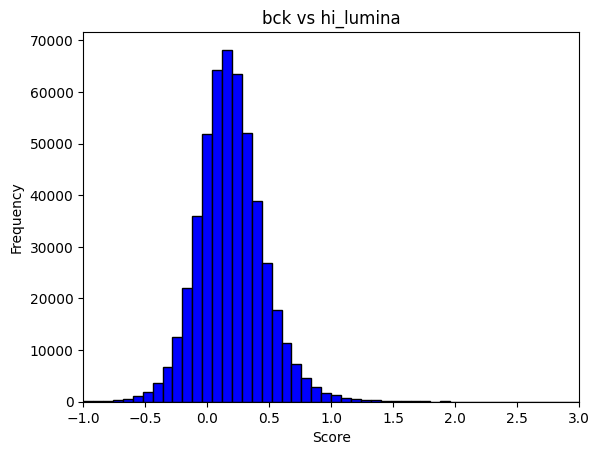

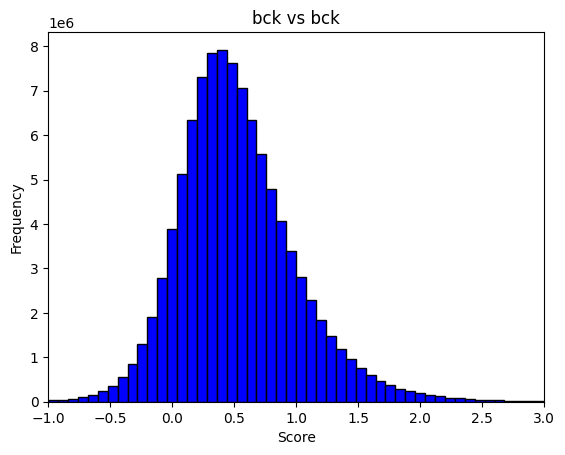

[[-0.10174935 -0.36037892 -0.40525281 -0.6985541  -1.54457045]
 [-0.36037892  0.00824592 -0.65473408 -0.48183414 -1.99185121]
 [-0.40525281 -0.6547339  -0.29155841 -0.58323073 -1.74140131]
 [-0.69855392 -0.48183414 -0.58323073 -0.48668256 -1.71784079]
 [-1.54457045 -1.99185121 -1.74140131 -1.71784079 -3.44131804]]
[[ 3.43074274  1.61604524  2.14560366  1.0743494   4.62184954]
 [ 1.61604548  4.82558203  1.90030122  1.4867661   3.84743571]
 [ 2.14560366  1.90030086  4.06748056  2.1984036   4.95881605]
 [ 1.07434988  1.4867661   2.1984036   2.90167236  4.16368246]
 [ 4.62184954  3.84743571  4.95881605  4.16368294 33.52658463]]
[[0.60047102 0.53106624 0.42575532 0.29416814 0.31608477]
 [0.53106624 0.74265587 0.44369844 0.33378646 0.26142004]
 [0.42575532 0.44369844 0.53456503 0.34058681 0.2203407 ]
 [0.29416817 0.33378646 0.34058684 0.46438944 0.19214669]
 [0.31608468 0.26142001 0.22034062 0.19214667 0.5257085 ]]


In [ ]:
mins = np.zeros((5,5))
maxes = np.zeros((5,5))
means = np.zeros((5,5))
for kw1 in range(0,5):
    for kw2 in range(0,5):
        keyword1, keyword2 = keywords[kw1],  keywords[kw2]
        medoid1, medoid2 = medoids[kw1], medoids[kw2]
        keyword_scores = np.matmul(medoid1, medoid2.T)
        mins[kw1, kw2] = keyword_scores.min()
        maxes[kw1, kw2] = keyword_scores.max()
        means[kw1, kw2] = keyword_scores.mean()
        plt.hist(keyword_scores.flatten(), bins=50, range=(-1, 3), color='blue', edgecolor='black')

        plt.title(f'{keyword1} vs {keyword2}')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.xlim(-1, 3)
        plt.show()


print(mins)
print(maxes)
print(means)

## 7. Observe Performance on DML space

In [ ]:
model.to(device)
keywords = ['hey_snapdragon', 'hi_galaxy', 'hey_android', 'hi_lumina']
medoids = []
data_shape = 64
test_set = np.empty((0, data_shape))
targets_set = np.empty((0,), dtype=int)
for label, keyword in enumerate(keywords):
    keyword_waveform = test_features[keyword]['raw']
    emb_kwrd = model(torch.from_numpy(keyword_waveform).float().to(device).permute(0, 2, 1))
    emb_kwrd = sigma2.forward_one(emb_kwrd).detach().cpu().numpy()
    train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
    data = np.load(train_test_split_address, allow_pickle=True)
    training_indexes = data.f.training_indexes
    test_indexes = data.f.test_indexes
    train_samples = emb_kwrd[training_indexes]
    test_samples = emb_kwrd[test_indexes]
    targets = label*np.ones((test_samples.shape[0],), dtype=int)
    test_set = np.concatenate((test_set, test_samples), axis=0)
    targets_set = np.concatenate((targets_set, targets), axis=0)
    medoids.append(train_samples)
background_waveform = test_features['background']['raw']
emb_bck = model(torch.from_numpy(background_waveform).float().to(device).permute(0, 2, 1))
emb_bck = sigma2.forward_one(emb_bck).detach().cpu().numpy()
train_samples = emb_bck[:10000]
test_samples = emb_bck[10000:]
targets = 4*np.ones((test_samples.shape[0],), dtype=int)
test_set = np.concatenate((test_set, test_samples), axis=0)
targets_set = np.concatenate((targets_set, targets), axis=0)
medoids.append(train_samples)

0.5486421963592958
Confusion matrix, without normalization
[[ 971   33   32   23    4]
 [  17  837    5   26    0]
 [  56   56  838  109    5]
 [   3   10   23 1025    2]
 [1815  312  190  304    6]]


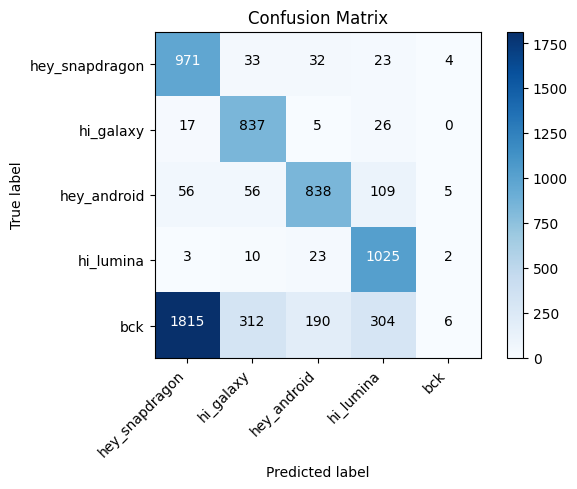

In [ ]:
classes = set(np.squeeze(targets_set))
acc, conf_mat = calc_acc(classes, test_set, medoids, th=3, return_confmat=True)
print(acc)
keywords.append('bck')
plot_confusion_matrix(conf_mat,keywords)

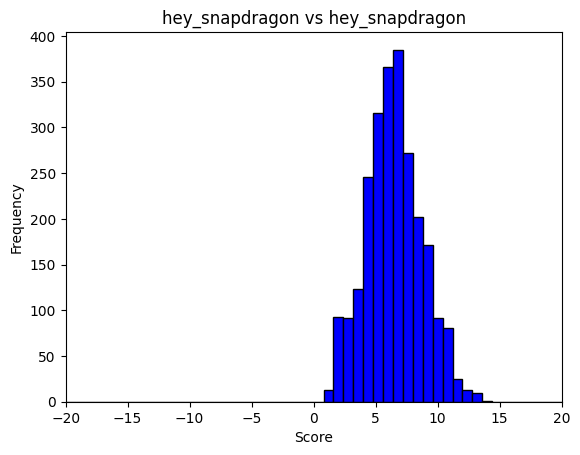

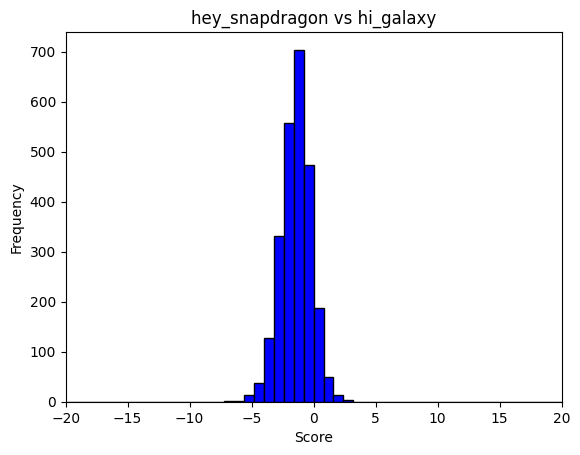

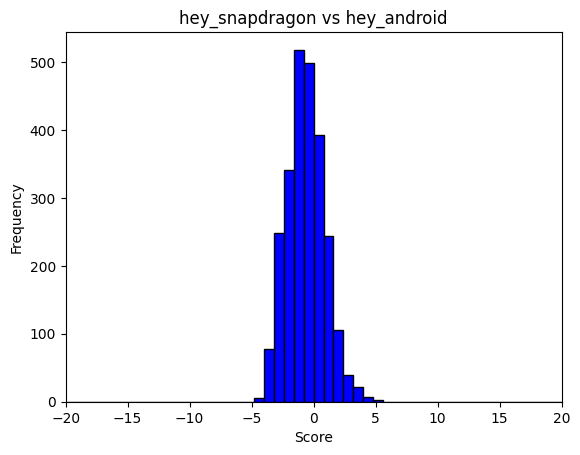

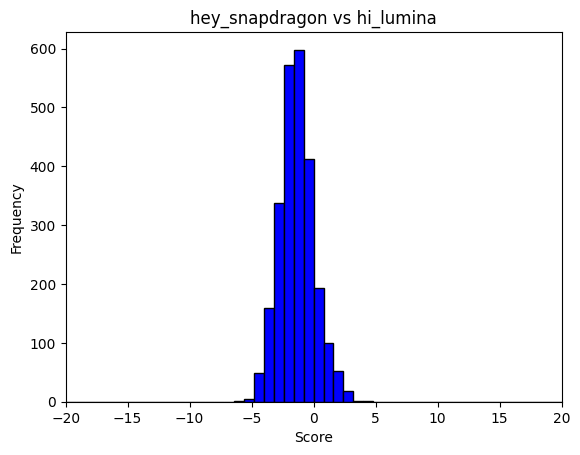

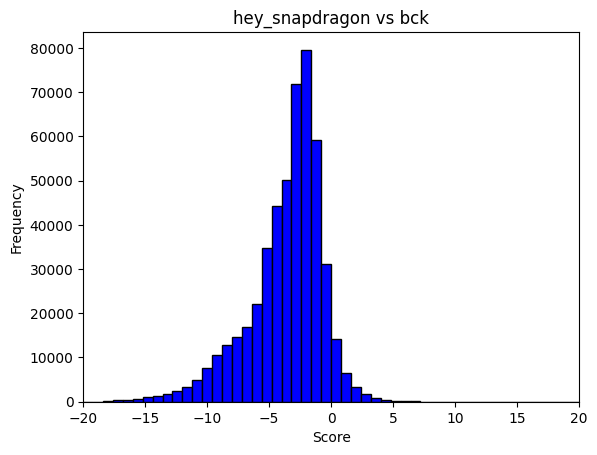

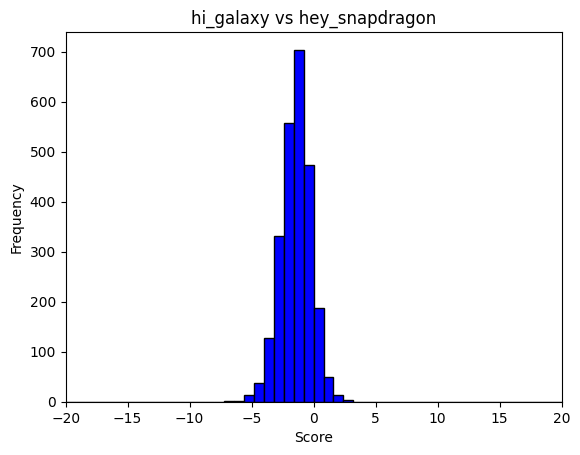

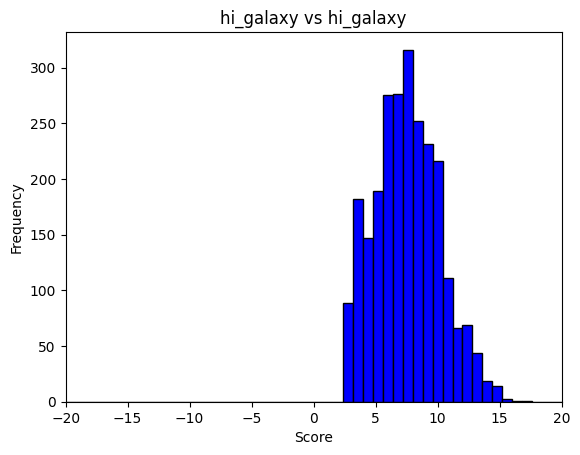

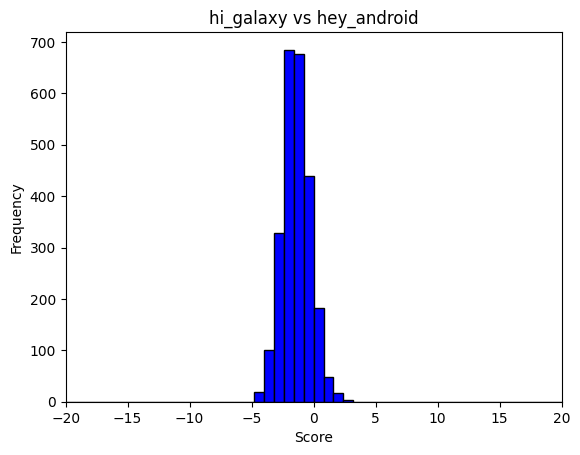

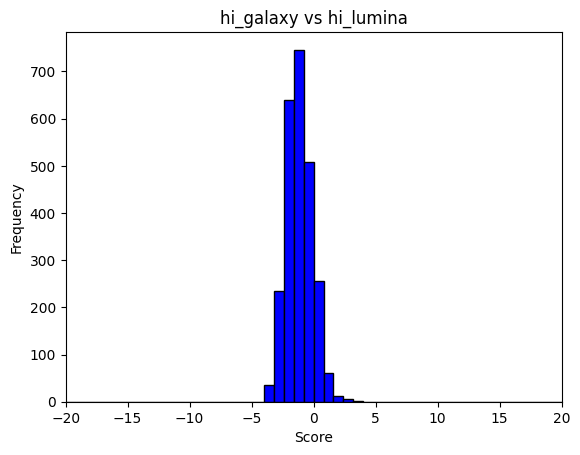

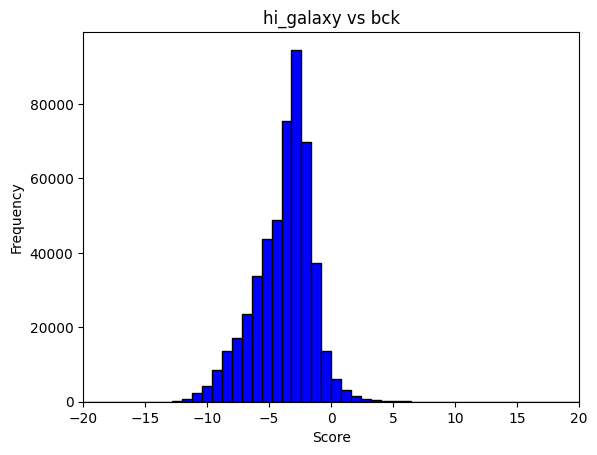

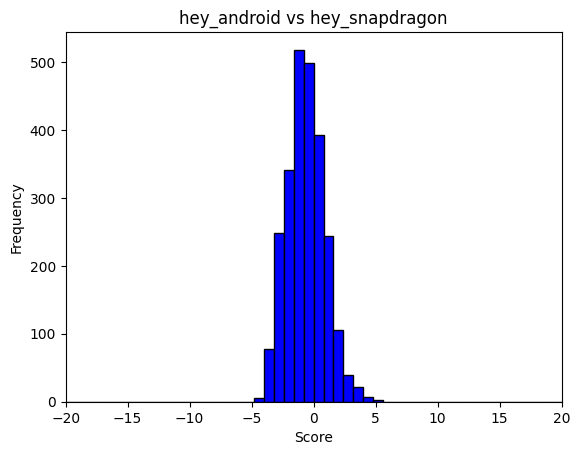

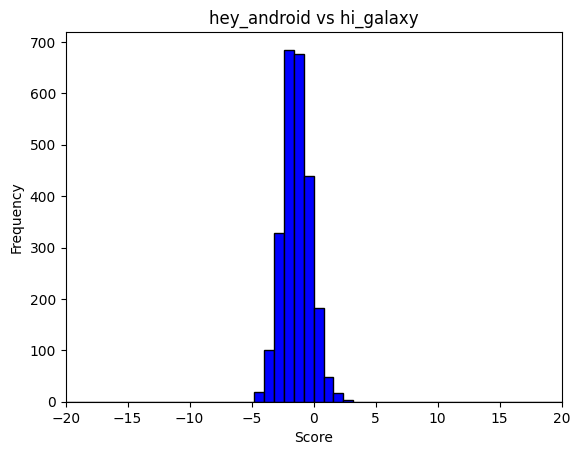

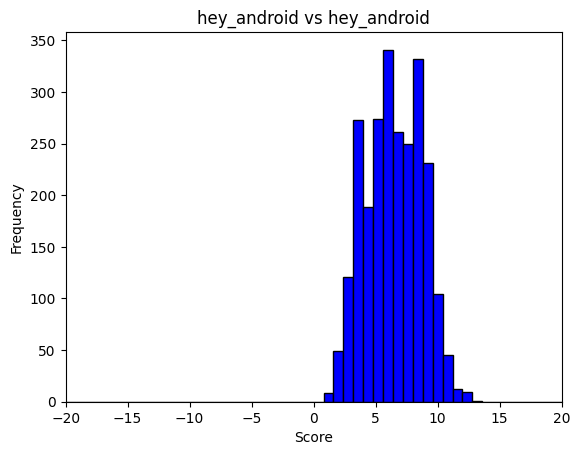

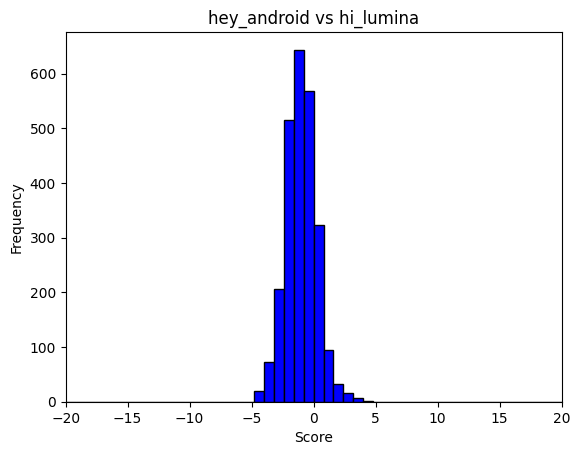

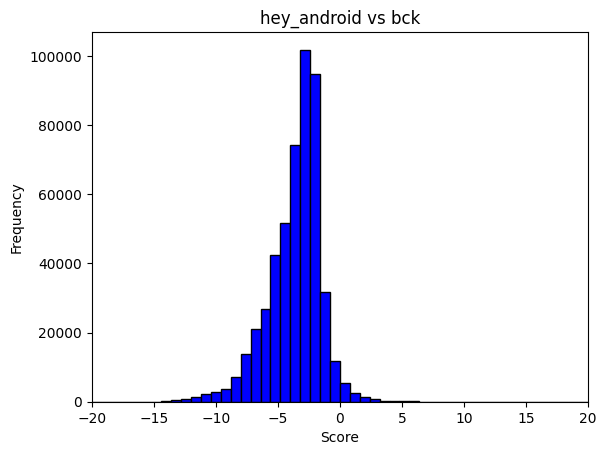

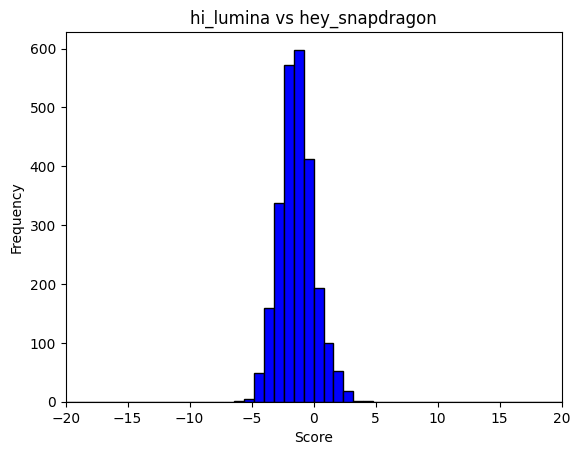

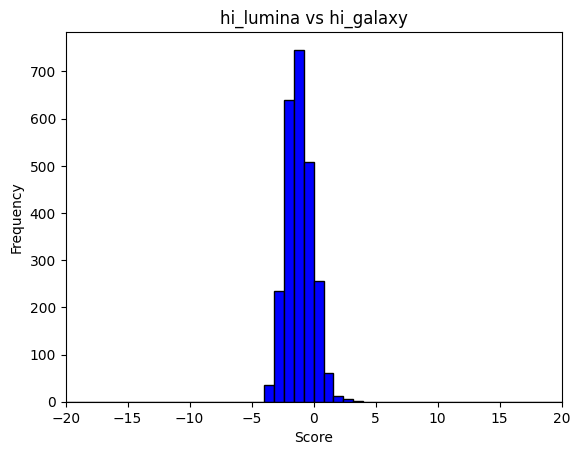

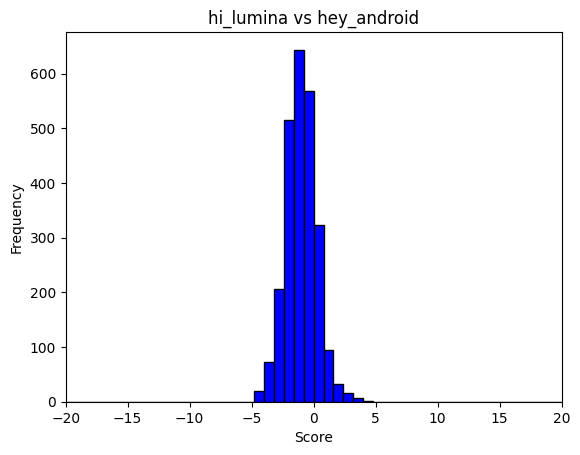

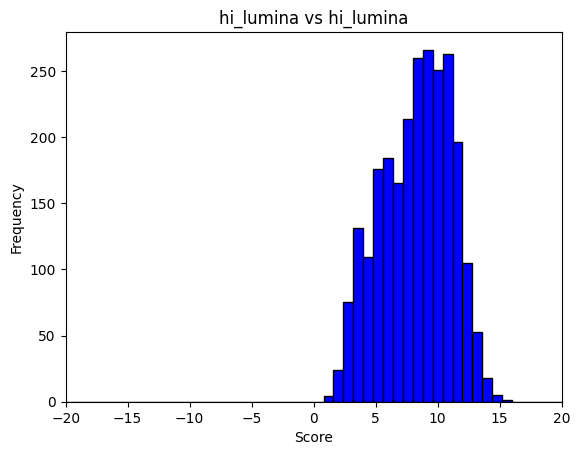

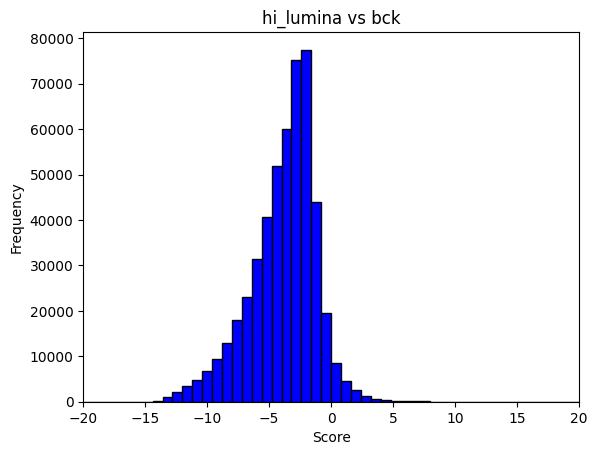

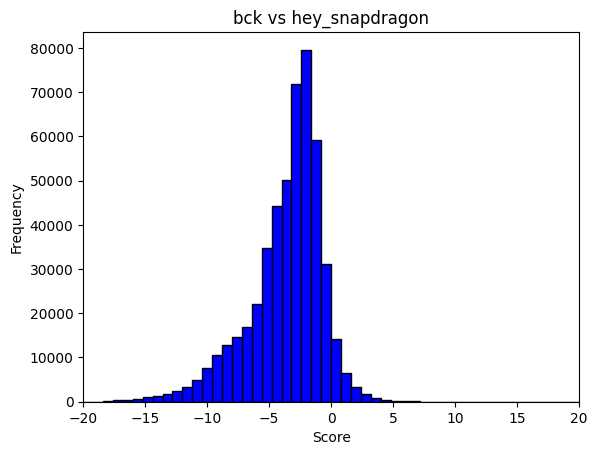

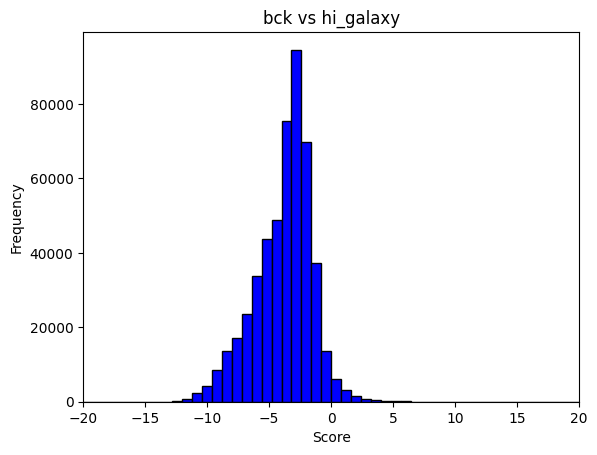

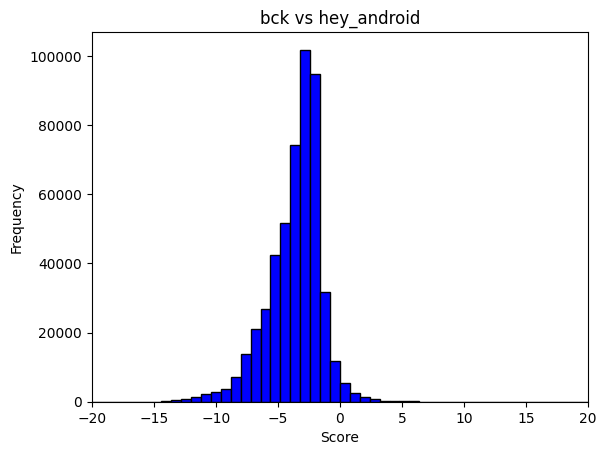

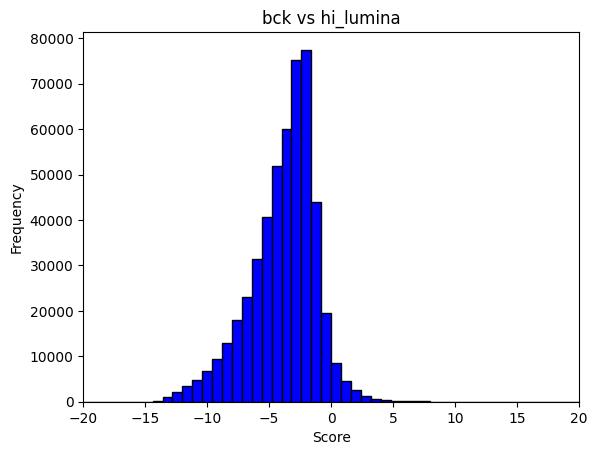

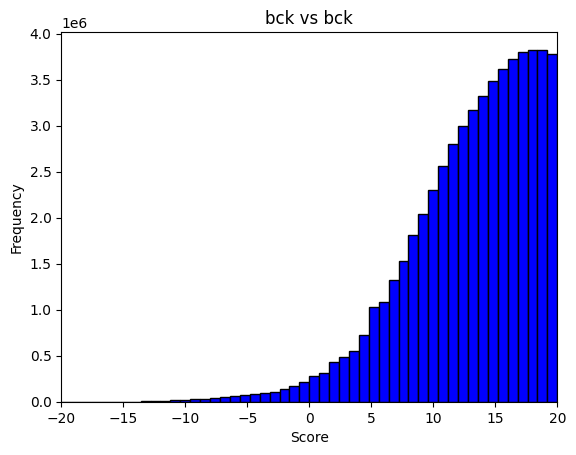

[[  1.00676239  -6.87280083  -4.48924255  -5.60363865 -20.44801521]
 [ -6.87280083   2.5563972   -4.43676329  -3.92348146 -13.52819347]
 [ -4.48924351  -4.43676329   0.97836041  -4.75835991 -14.64563942]
 [ -5.60363865  -3.92348146  -4.75835991   1.45380759 -15.16152763]
 [-20.44801521 -13.52819347 -14.64563942 -15.16152763 -18.71725845]]
[[13.84222412  2.64933562  5.43380737  4.61034584 11.62649441]
 [ 2.64933562 16.81452751  2.49391365  3.27273774  9.56730747]
 [ 5.43380737  2.49391484 13.00757408  4.5036478   8.78424072]
 [ 4.61034679  3.27273774  4.5036478  15.56441689  9.31610489]
 [11.62649441  9.56730747  8.78424072  9.31610489 56.4297905 ]]
[[ 6.45693922 -1.44056988 -0.64242131 -1.3659699  -3.63111138]
 [-1.44056976  7.52865696 -1.43025959 -1.16701794 -3.830441  ]
 [-0.64242125 -1.43025959  6.44355059 -1.03250825 -3.62160754]
 [-1.3659699  -1.16701794 -1.03250825  8.23026276 -3.86995625]
 [-3.63111138 -3.83044076 -3.6216073  -3.86995697 18.88368607]]


In [ ]:
mins = np.zeros((5,5))
maxes = np.zeros((5,5))
means = np.zeros((5,5))
for kw1 in range(0,5):
    for kw2 in range(0,5):
        keyword1, keyword2 = keywords[kw1],  keywords[kw2]
        medoid1, medoid2 = medoids[kw1], medoids[kw2]
        keyword_scores = np.matmul(medoid1, medoid2.T)
        mins[kw1, kw2] = keyword_scores.min()
        maxes[kw1, kw2] = keyword_scores.max()
        means[kw1, kw2] = keyword_scores.mean()
        plt.hist(keyword_scores.flatten(), bins=50, range=(-20, 20), color='blue', edgecolor='black')

        plt.title(f'{keyword1} vs {keyword2}')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.xlim(-20, 20)
        plt.show()


print(mins)
print(maxes)
print(means)

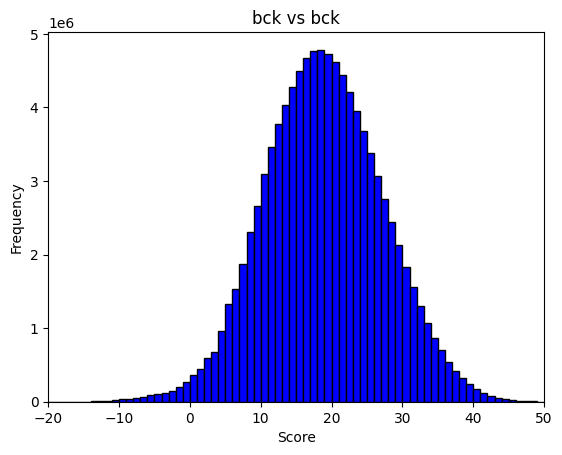

In [ ]:
keyword1, keyword2 = keywords[4],  keywords[4]
medoid1, medoid2 = medoids[4], medoids[4]
keyword_scores = np.matmul(medoid1, medoid2.T)
mins[kw1, kw2] = keyword_scores.min()
maxes[kw1, kw2] = keyword_scores.max()
means[kw1, kw2] = keyword_scores.mean()
plt.hist(keyword_scores.flatten(), bins=70, range=(-20, 50), color='blue', edgecolor='black')

plt.title(f'{keyword1} vs {keyword2}')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xlim(-20, 50)
plt.show()

In [ ]:
training_set = np.vstack(medoids)
training_labels = np.hstack([[i]*medoids[i].shape[0] for i in range(5)]).flatten()

In [ ]:
training_set.shape

(10200, 64)

## 8. write two get-batches: (1) inter-class separation (2) class vs background

In [ ]:
def get_batch_classes(data, targets, batch_size=32):

    K = len(set(np.squeeze(targets)))
    data_dim = data.shape[1]
    targets = np.asarray(targets)
    anchor = np.zeros((batch_size, data_dim))
    friend = np.zeros((batch_size, data_dim))
    foe = np.zeros((batch_size, data_dim))

    for k in range(batch_size):
        c1, c2 = random.sample(range(K-1), 2)    #Chooses k unique random elements from a population sequence or set.
        friend_clas_indices = np.where(targets == c1)[0]
        foe_clas_indices = np.where(targets == c2)[0]

        anchor_inx, friend_inx = random.sample(list(friend_clas_indices), 2)
        foe_inx = random.sample(list(foe_clas_indices),1) [0]
        anchor[k, :] = data[anchor_inx]
        friend[k,  :] = data[friend_inx]
        foe[k, :] = data[foe_inx]

    friend_label = np.ones(batch_size)
    foe_label = np.zeros(batch_size)

    batch_1 = torch.from_numpy(np.concatenate((anchor, anchor), axis = 0)).to('cuda:0')
    batch_2 = torch.from_numpy(np.concatenate((friend, foe),  axis = 0)).to('cuda:0')
    label = torch.from_numpy(np.concatenate((friend_label, foe_label))).to('cuda:0')

    return batch_1.float(), batch_2.float(), label

def get_batch_bck(data, targets):
    data = training_set
    targets = training_labels
    K = len(set(np.squeeze(targets)))
    c2 = K-1    #为啥是K-1啊
    friend_inx = np.where(targets != c2)[0]
    foe_clas_indices = np.where(targets == c2)[0]
    foe_inx = random.sample(list(foe_clas_indices), len(friend_inx))
    data_dim = data.shape[1]
    targets = np.asarray(targets)
    anchor = np.zeros((len(friend_inx), data_dim))
    friend = np.zeros((len(friend_inx), data_dim))
    foe = np.zeros((len(friend_inx), data_dim))
    for k in range(len(friend_inx)):
        anchor[k,  :] = data[friend_inx[k]]
        foe[k, :] = data[foe_inx[k]]
    foe_label = np.zeros(len(friend_inx))
    batch_1 = torch.from_numpy(anchor).to('cuda:0')
    batch_2 = torch.from_numpy(foe).to('cuda:0')
    label = torch.from_numpy(foe_label).to('cuda:0')

    return batch_1.float(), batch_2.float(), label

Similar as step 5

In [ ]:
model.cuda()
medoids = []
data_shape = 128
test_set = np.empty((0, data_shape))
targets_set = np.empty((0,), dtype=int)
keywords = ['hey_snapdragon',
 'hi_galaxy',
 'hey_android',
 'hi_lumina']

for label, keyword in enumerate(keywords):
    keyword_waveform = test_features[keyword]['raw']
    emb_kwrd = model(torch.from_numpy(keyword_waveform).float().cuda().permute(0, 2, 1)).detach().cpu().numpy()
    train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
    data = np.load(train_test_split_address, allow_pickle=True)
    training_indexes = data.f.training_indexes
    test_indexes = data.f.test_indexes
    train_samples = emb_kwrd[training_indexes]
    test_samples = emb_kwrd[test_indexes]
    targets = label*np.ones((test_samples.shape[0],), dtype=int)
    test_set = np.concatenate((test_set, test_samples), axis=0)
    targets_set = np.concatenate((targets_set, targets), axis=0)
    medoids.append(train_samples)
background_waveform = test_features['background']['raw']
emb_bck = model(torch.from_numpy(background_waveform).float().cuda().permute(0, 2, 1)).detach().cpu().numpy()
train_samples = emb_bck[:10000]
test_samples = emb_bck[10000:]
targets = 4*np.ones((test_samples.shape[0],), dtype=int)
test_set = np.concatenate((test_set, test_samples), axis=0)
targets_set = np.concatenate((targets_set, targets), axis=0)
medoids.append(train_samples)

In [ ]:
training_set = np.vstack(medoids)
training_labels = np.hstack([[i]*medoids[i].shape[0] for i in range(5)]).flatten()

## 9. Train DML observe 3M (as well as class-bck distributions) every epoch determine threshold

0.5483437779767234
[[ 967   35   33   25    3]
 [  11  841    5   28    0]
 [  53   58  838  111    4]
 [   3   10   22 1026    2]
 [1782  321  204  317    3]]
0.7257535064159952
[[  15  138  154  167  589]
 [   0  861    2   16    6]
 [   0   74  889   79   22]
 [   0   12   23 1011   17]
 [   3  233  137  166 2088]]
0.7934944792599224
[[ 168   88   96   64  647]
 [   0  853    3   14   15]
 [   0   43  861   63   97]
 [   0    6   17  985   55]
 [   0   75   39   62 2451]]
0.7876753207997612
[[ 153   44   46   30  790]
 [   0  823    3   12   47]
 [   0   18  807   35  204]
 [   0    1   10  934  118]
 [   0   28   16   21 2562]]
0.7735004476275739
[[ 157   23   20   12  851]
 [   0  791    2   10   82]
 [   0    9  737   16  302]
 [   0    1    6  895  161]
 [   0   10    5    8 2604]]
0.7527603700387944
[[ 134    9   15    5  900]
 [   0  748    1    9  127]
 [   0    4  690    6  364]
 [   0    0    5  855  203]
 [   0    4    3    2 2618]]
0.7487317218740674
[[ 178    9   10    4

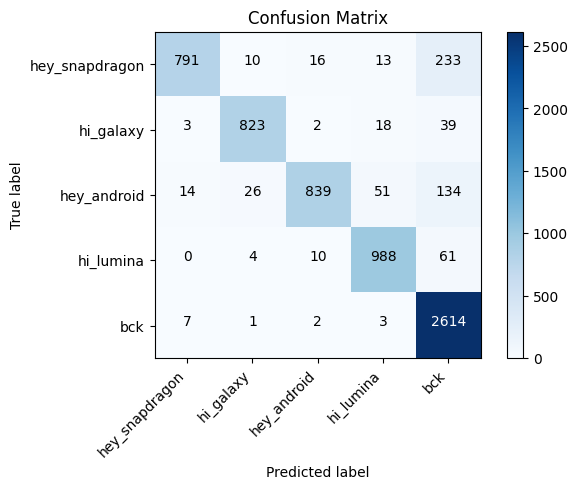

In [ ]:
device = 'cuda:0'
lr = 0.0003
margin = 0.9
batch_size = 128
model.to(device)
# sigma2 = DML2()
sigma2.float().to(device).train()
optimizer = torch.optim.Adam(sigma2.parameters(), lr=lr)
optimizer.zero_grad()
loss_fn = MaskedXentMarginLoss(margin=margin)
data_shape = 64
for i in range(10000):
    anchor, alien, labels = get_batch_bck(training_set, training_labels)
    optimizer.zero_grad()
    output = sigma2.forward(anchor, alien)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()
    if not i%2:
        anchor, alien, labels = get_batch_classes(training_set, training_labels, batch_size=batch_size)
        optimizer.zero_grad()
        output = sigma2.forward(anchor, alien)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
    if not i%200:    #到10000应该是差一个循环
        medoids = []
        test_set = np.empty((0, data_shape))
        targets_set = np.empty((0,), dtype=int)
        keywords = ['hey_snapdragon',
         'hi_galaxy',
         'hey_android',
         'hi_lumina']
        for label, keyword in enumerate(keywords):
            keyword_waveform = test_features[keyword]['raw']
            emb_kwrd = model(torch.from_numpy(keyword_waveform).float().to(device).permute(0, 2, 1))
            emb_kwrd = sigma2.forward_one(emb_kwrd).detach().cpu().numpy()
            train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
            data = np.load(train_test_split_address, allow_pickle=True)
            training_indexes = data.f.training_indexes
            test_indexes = data.f.test_indexes
            train_samples = emb_kwrd[training_indexes]
            test_samples = emb_kwrd[test_indexes]
            targets = label*np.ones((test_samples.shape[0],), dtype=int)
            test_set = np.concatenate((test_set, test_samples), axis=0)
            targets_set = np.concatenate((targets_set, targets), axis=0)
            medoids.append(train_samples)
        background_waveform = test_features['background']['raw']
        emb_bck = model(torch.from_numpy(background_waveform).float().to(device).permute(0, 2, 1))
        emb_bck = sigma2.forward_one(emb_bck).detach().cpu().numpy()
        train_samples = emb_bck[:10000]
        test_samples = emb_bck[10000:]
        targets = 4*np.ones((test_samples.shape[0],), dtype=int)
        test_set = np.concatenate((test_set, test_samples), axis=0)
        targets_set = np.concatenate((targets_set, targets), axis=0)
        medoids.append(train_samples)
        classes = set(np.squeeze(targets_set))
        acc, conf_mat = calc_acc(classes, test_set, medoids, th=3, return_confmat=True)
        print(acc)
        print(conf_mat)
keywords.append('bck')
plot_confusion_matrix(conf_mat,keywords)

0.9256938227394808
[[ 928   25   39   24   47]
 [   9  847    3   19    7]
 [  34   39  913   61   17]
 [   4   12   20 1017   10]
 [  51   20   16   41 2499]]
Confusion matrix, without normalization
[[ 928   25   39   24   47]
 [   9  847    3   19    7]
 [  34   39  913   61   17]
 [   4   12   20 1017   10]
 [  51   20   16   41 2499]]


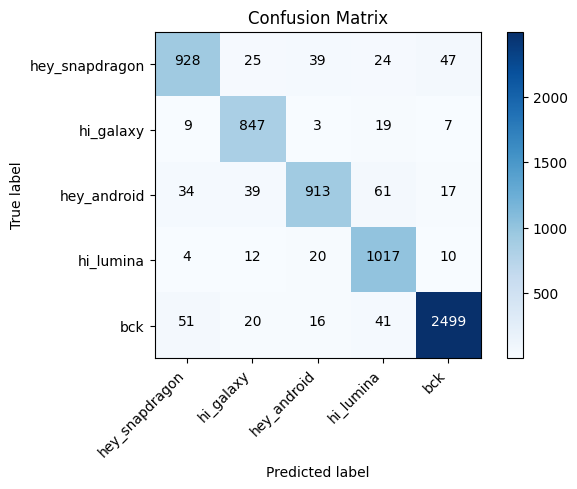

In [ ]:
medoids = []
test_set = np.empty((0, data_shape))
targets_set = np.empty((0,), dtype=int)
keywords = ['hey_snapdragon',
 'hi_galaxy',
 'hey_android',
 'hi_lumina']
for label, keyword in enumerate(keywords):
    keyword_waveform = test_features[keyword]['raw']
    emb_kwrd = model(torch.from_numpy(keyword_waveform).float().to(device).permute(0, 2, 1))
    emb_kwrd = sigma2.forward_one(emb_kwrd).detach().cpu().numpy()
    train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
    data = np.load(train_test_split_address, allow_pickle=True)
    training_indexes = data.f.training_indexes
    test_indexes = data.f.test_indexes
    train_samples = emb_kwrd[training_indexes]
    test_samples = emb_kwrd[test_indexes]
    targets = label*np.ones((test_samples.shape[0],), dtype=int)
    test_set = np.concatenate((test_set, test_samples), axis=0)
    targets_set = np.concatenate((targets_set, targets), axis=0)
    medoids.append(train_samples)
background_waveform = test_features['background']['raw']
emb_bck = model(torch.from_numpy(background_waveform).float().to(device).permute(0, 2, 1))
emb_bck = sigma2.forward_one(emb_bck).detach().cpu().numpy()
train_samples = emb_bck[:10000]
test_samples = emb_bck[10000:]
targets = 4*np.ones((test_samples.shape[0],), dtype=int)
test_set = np.concatenate((test_set, test_samples), axis=0)
targets_set = np.concatenate((targets_set, targets), axis=0)
medoids.append(train_samples)
classes = set(np.squeeze(targets_set))
acc, conf_mat = calc_acc(classes, test_set, medoids, th=-0.01, return_confmat=True)
print(acc)
print(conf_mat)
keywords.append('bck')
plot_confusion_matrix(conf_mat,keywords)

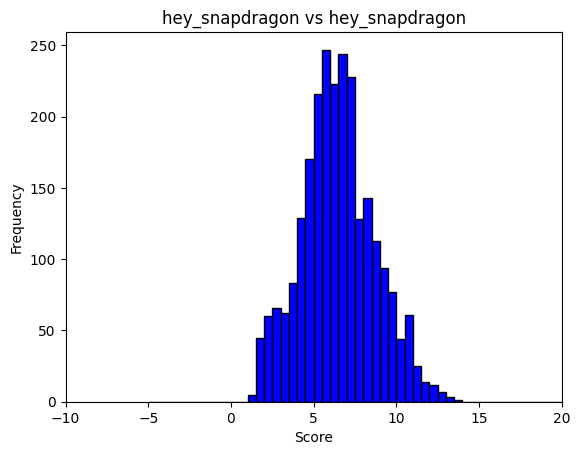

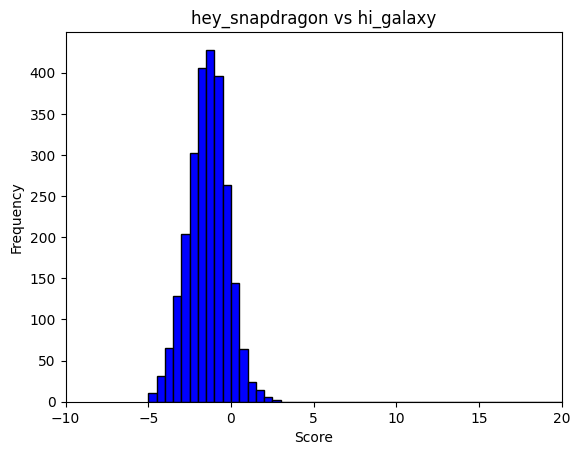

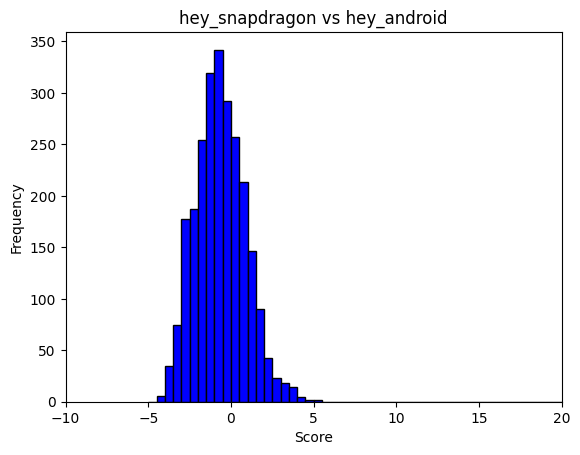

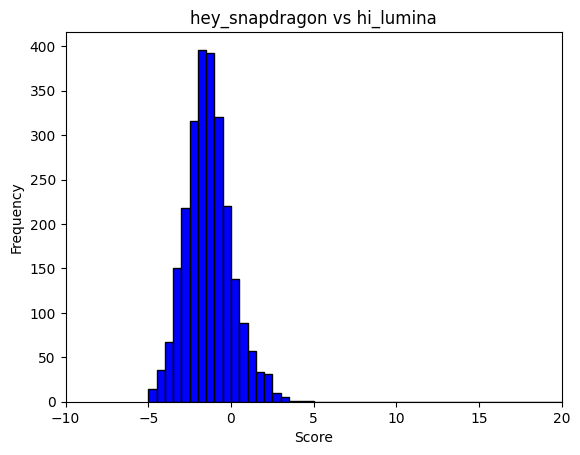

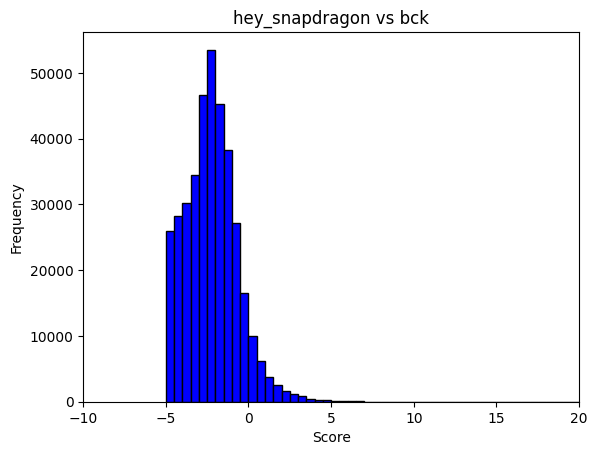

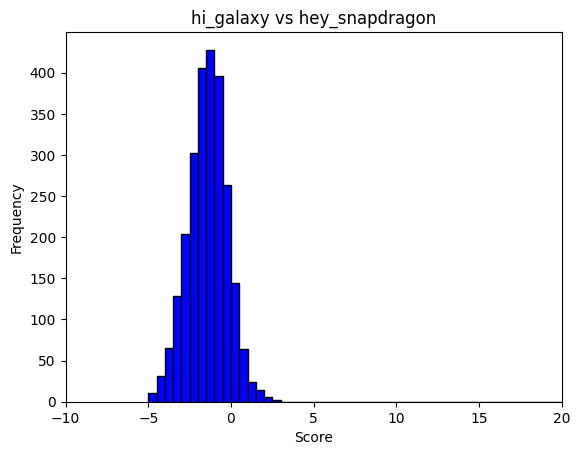

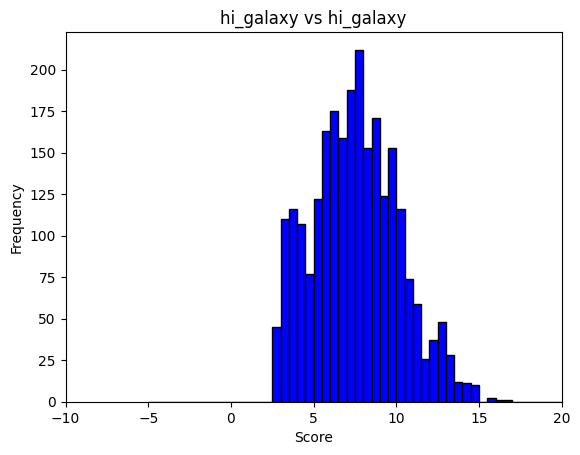

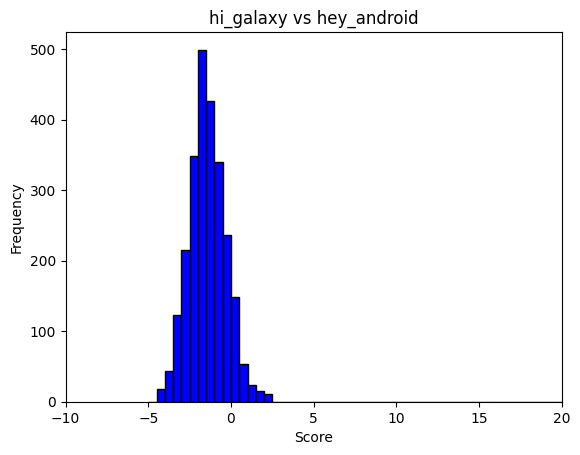

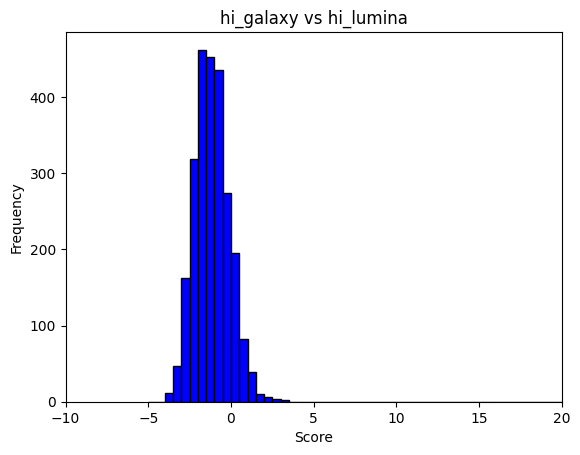

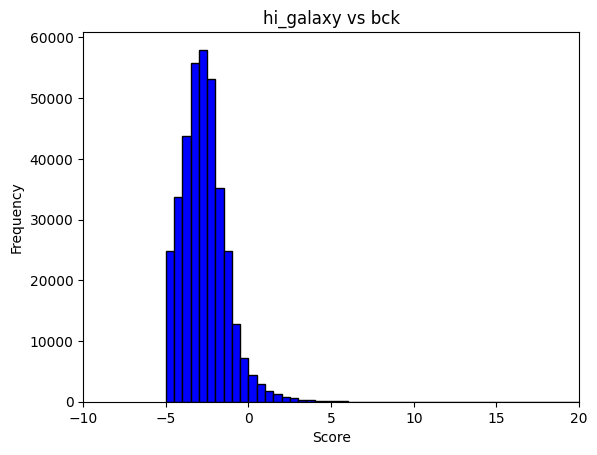

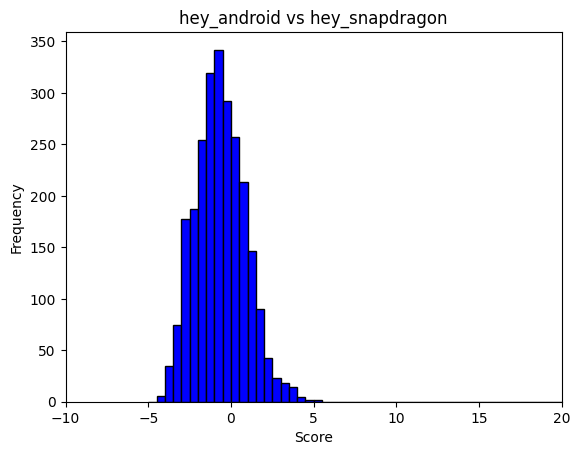

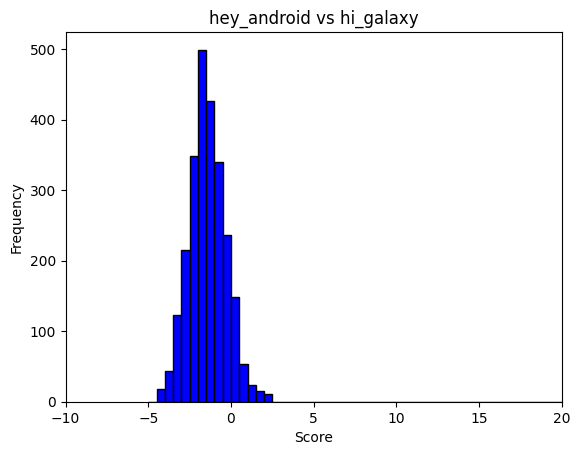

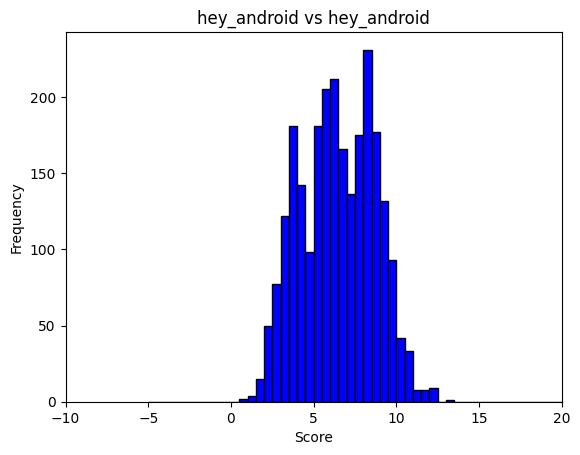

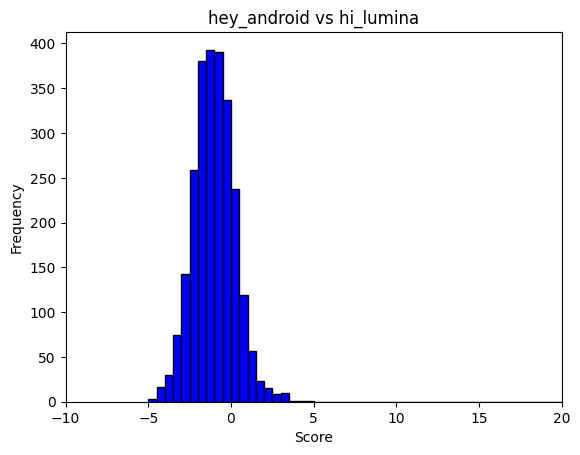

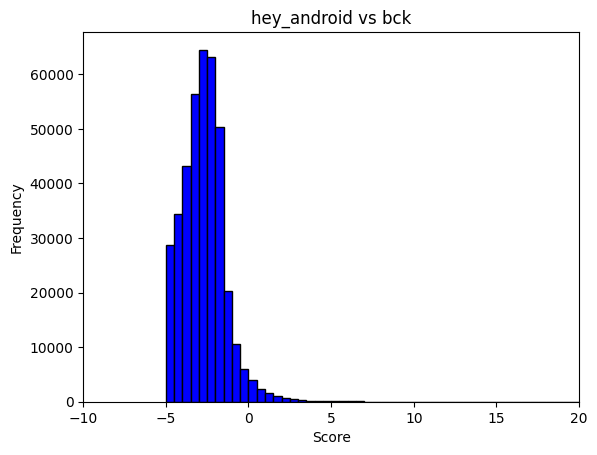

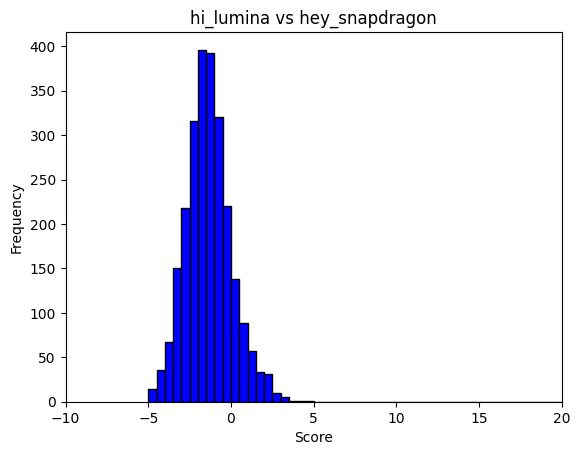

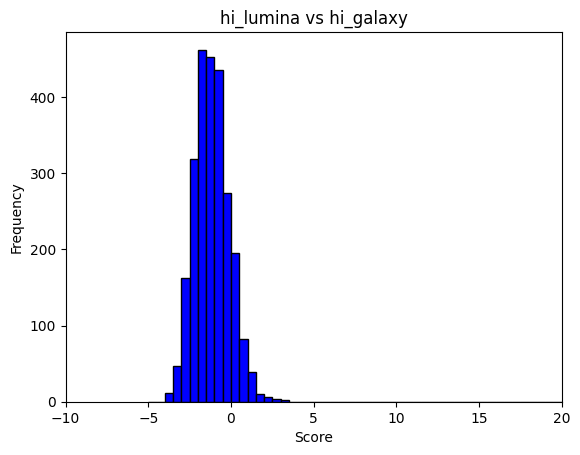

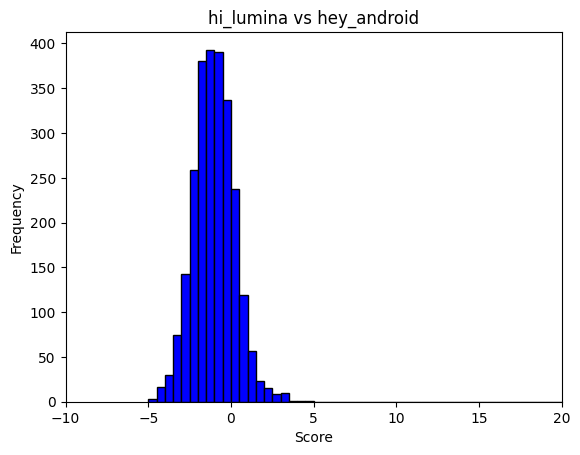

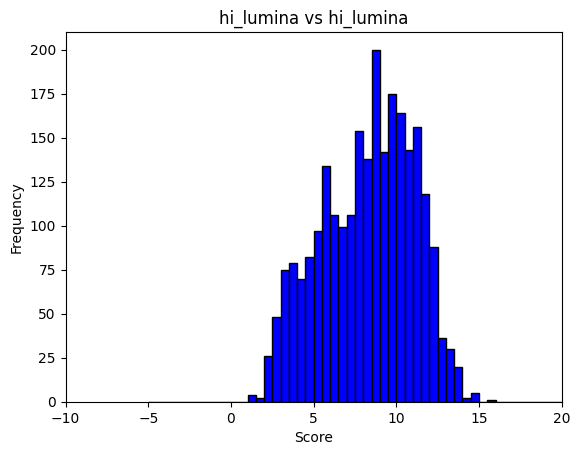

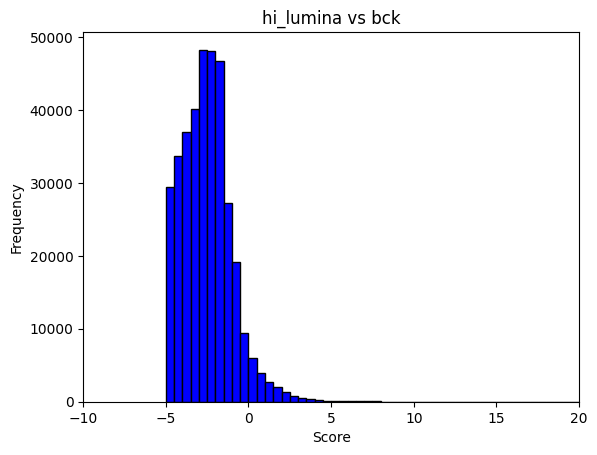

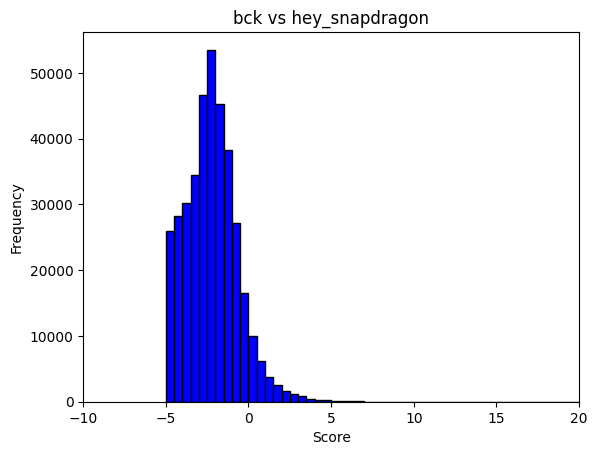

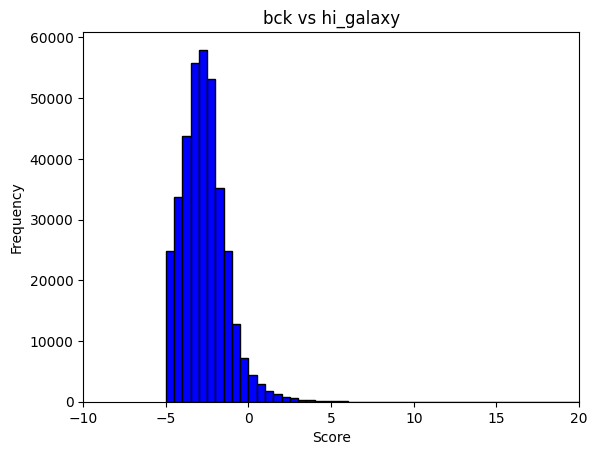

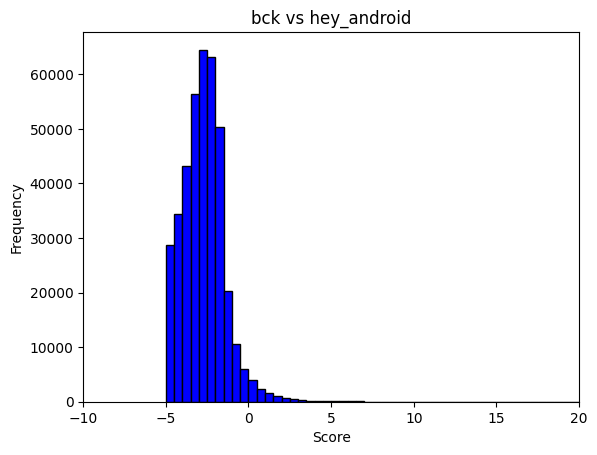

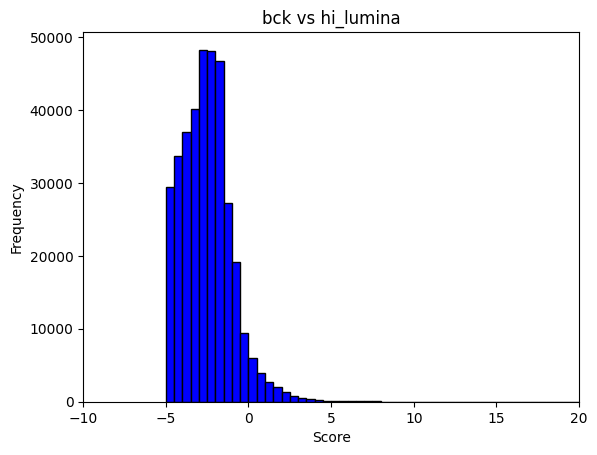

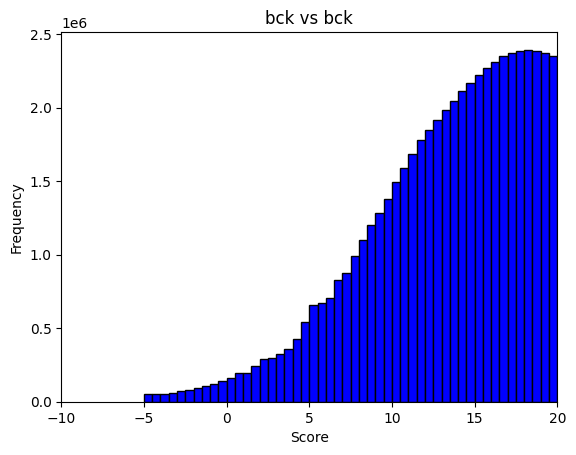

[[  1.00676239  -6.87280083  -4.48924255  -5.60363865 -20.44801521]
 [ -6.87280083   2.5563972   -4.43676329  -3.92348146 -13.52819347]
 [ -4.48924351  -4.43676329   0.97836041  -4.75835991 -14.64563942]
 [ -5.60363865  -3.92348146  -4.75835991   1.45380759 -15.16152763]
 [-20.44801521 -13.52819347 -14.64563942 -15.16152763 -18.71725845]]
[[13.84222412  2.64933562  5.43380737  4.61034584 11.62649441]
 [ 2.64933562 16.81452751  2.49391365  3.27273774  9.56730747]
 [ 5.43380737  2.49391484 13.00757408  4.5036478   8.78424072]
 [ 4.61034679  3.27273774  4.5036478  15.56441689  9.31610489]
 [11.62649441  9.56730747  8.78424072  9.31610489 56.4297905 ]]
[[ 6.45693922 -1.44056988 -0.64242131 -1.3659699  -3.63111138]
 [-1.44056976  7.52865696 -1.43025959 -1.16701794 -3.830441  ]
 [-0.64242125 -1.43025959  6.44355059 -1.03250825 -3.62160754]
 [-1.3659699  -1.16701794 -1.03250825  8.23026276 -3.86995625]
 [-3.63111138 -3.83044076 -3.6216073  -3.86995697 18.88368607]]


In [ ]:
mins = np.zeros((5,5))
maxes = np.zeros((5,5))
means = np.zeros((5,5))
keywords.append('bck')
for kw1 in range(0,5):
    for kw2 in range(0,5):
        keyword1, keyword2 = keywords[kw1],  keywords[kw2]
        medoid1, medoid2 = medoids[kw1], medoids[kw2]
        keyword_scores = np.matmul(medoid1, medoid2.T)
        mins[kw1, kw2] = keyword_scores.min()
        maxes[kw1, kw2] = keyword_scores.max()
        means[kw1, kw2] = keyword_scores.mean()
        plt.hist(keyword_scores.flatten(), bins=50, range=(-5, 20), color='blue', edgecolor='black')

        plt.title(f'{keyword1} vs {keyword2}')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.xlim(-10, 20)
        plt.show()


print(mins)
print(maxes)
print(means)

In [ ]:
def first_nonzero(arr, axis=0, invalid_val=-1):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def detect_miss_rate_at_1FApH(false_rates, miss_rates, thresholds):
    index = 0
    while True:
        if false_rates[index]>10:
            return miss_rates[index-1], false_rates[index-1], thresholds[index-1]
        index += 1

def detect_fa_rate_at_90recall(false_rates, miss_rates, thresholds):
    index = -1
    while True:
        if miss_rates[index]>0.1:
            return miss_rates[index], false_rates[index], thresholds[index]
        index -= 1

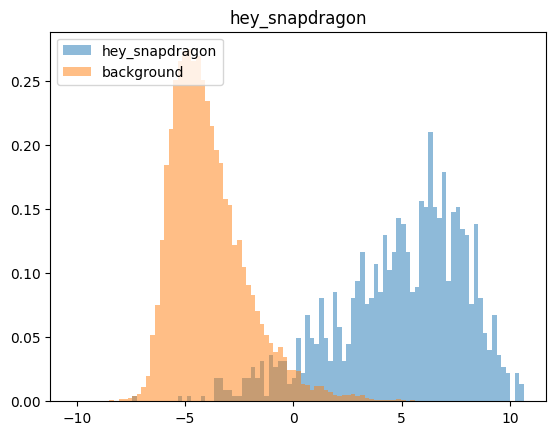

Calculating ROC


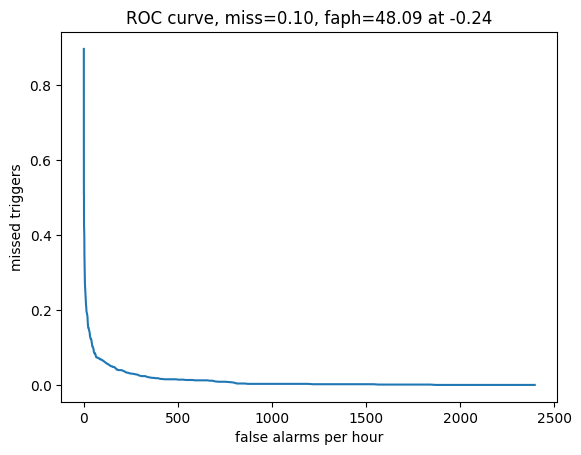

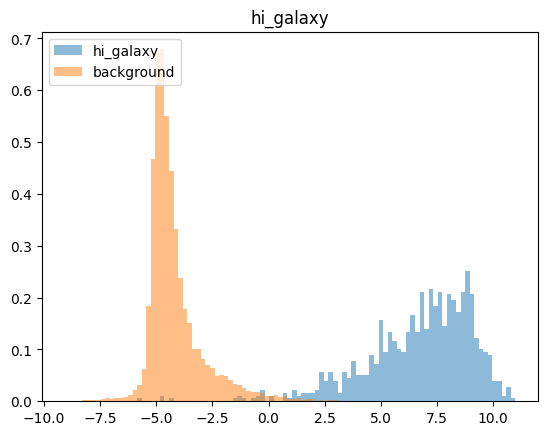

Calculating ROC


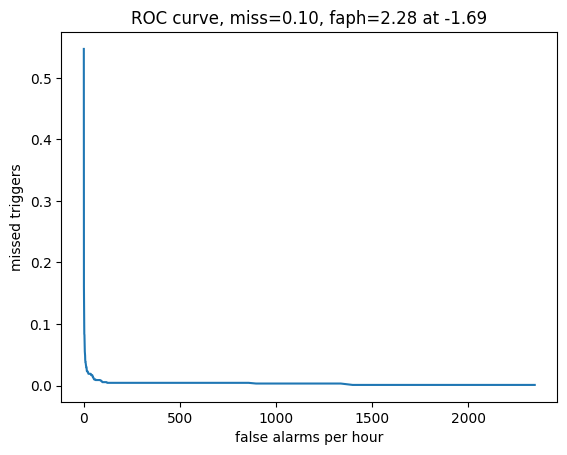

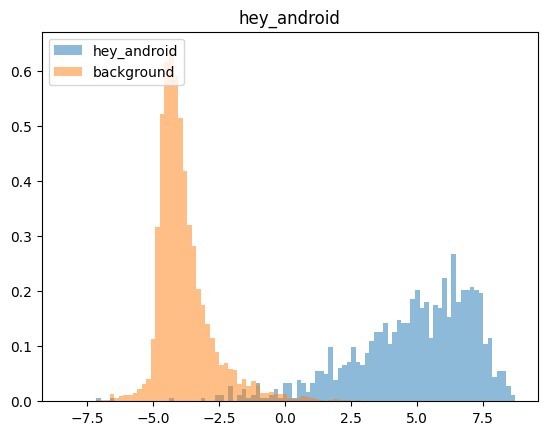

Calculating ROC


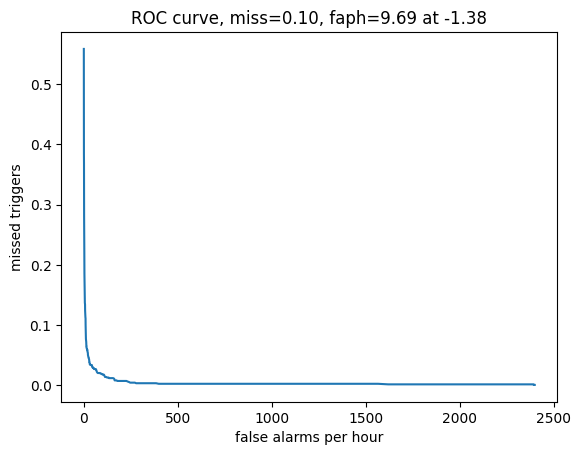

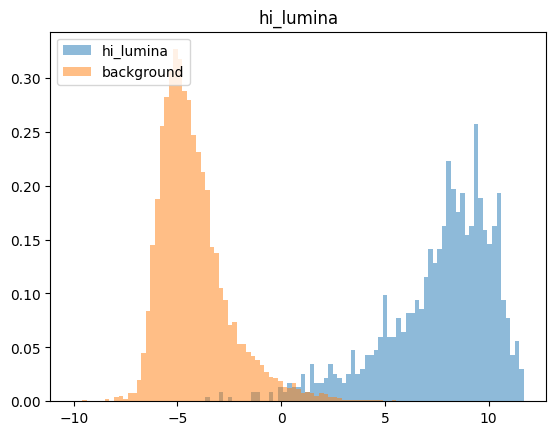

Calculating ROC


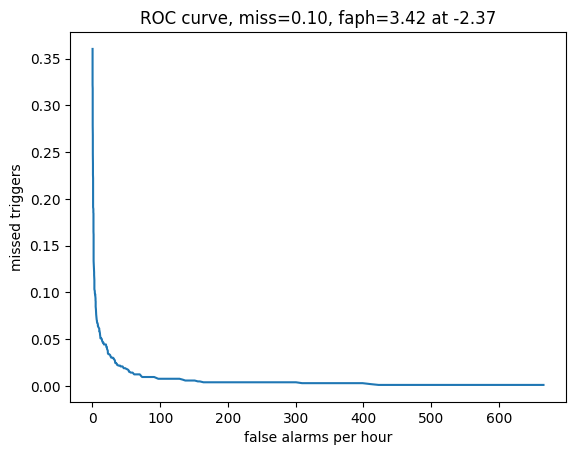

In [ ]:


keywords = ['hey_snapdragon',
 'hi_galaxy',
 'hey_android',
 'hi_lumina']
for keyword in keywords:
    keyword_waveform = test_features[keyword]['raw']
    emb_kwrd = model(torch.from_numpy(keyword_waveform).float().to(device).permute(0, 2, 1))
    emb_kwrd = sigma2.forward_one(emb_kwrd).detach().cpu().numpy()
    train_test_split_address = f'/content/drive/MyDrive/Colab Notebooks/Capstone/最新代码/data/{keyword}_train_test_split.npz'
    data = np.load(train_test_split_address, allow_pickle=True)
    training_indexes = data.f.training_indexes
    test_indexes = data.f.test_indexes
    train_samples = emb_kwrd[training_indexes]
    test_samples = emb_kwrd[test_indexes]

    background_waveform = test_features['background']['raw']
    emb_bck = model(torch.from_numpy(background_waveform).float().to(device).permute(0, 2, 1))
    emb_bck = sigma2.forward_one(emb_bck).detach().cpu().numpy()

    foes = np.zeros((emb_bck.shape[0],))
    keyword_scores = np.matmul(train_samples, test_samples.T)
    friends = np.mean(keyword_scores, axis=0)
    foes = np.mean(np.matmul(train_samples, emb_bck.T), axis=0)
    beg = min((min(friends), min(foes)))
    end = max((max(friends), max(foes)))
    bins = np.linspace(beg, end, 100)
    plt.hist(friends, bins, alpha=0.5, density=True,label=keyword)
    plt.legend(loc='upper left')
    plt.hist(foes, bins, alpha=0.5, density=True, label='background')
    plt.legend(loc='upper left')
    plt.title(f'{keyword}')
    plt.show()
    print('Calculating ROC')
    num_bins = 500
    roc_bins = np.linspace(beg, end, num_bins)
    miss_rate = np.zeros_like(roc_bins)
    false_rate = np.zeros_like(roc_bins)
    test_duration_in_hours = (foes.shape[0]*1.5)/(60*60)
    for i in range(num_bins):
        th = roc_bins[i]
        miss_rate[i] = sum(friends<th)/len(friends)
        false_rate[i] = sum(foes>th)/test_duration_in_hours

    false_rate_reversed = false_rate[::-1]
    miss_rate_reversed = miss_rate[::-1]
    inx = first_nonzero(false_rate_reversed)
    inx2 = num_bins - first_nonzero(miss_rate)
    miss, faph, th = detect_fa_rate_at_90recall(false_rate_reversed, miss_rate_reversed, roc_bins)
    plt.plot(false_rate_reversed[inx:inx2], miss_rate_reversed[inx:inx2])
    plt.title(f'ROC curve, miss={miss:.2f}, faph={faph:.2f} at {th:.2f}')
    plt.xlabel("false alarms per hour")
    plt.ylabel("missed triggers")
    plt.show()

**Findings:**  
The accuracy of the teacher model, which is Wav2Vec2 followed by a zero-shot DRL, on the background included training dataset was 93.93% and this is also the baseline of the student model, which is shown in another 'Baseline.ipynb' file. Even without the few-shot training, Wav2Vec2 can also get a very high accuracy on background included dataset, which is because it is a well-developed and well-trained mature self-supervised model. The corresponding confusion matrix was plotted to visualize the classification result.  
For the student model, accuracy scores are calculated in each stage of the training process for both background excluded dataset and background included dataset and they are compared with each other.   
First, a classification model yielded an accuracy of 76.66% following the application of the student model, conducted in the absence of any background noise. A confusion matrix without normalization was generated, depicting actual classes in the rows and predicted classes in the columns for the four keywords—“hey snapdragon,” “hi galaxy,” “hey android,” and “hi lumina”—extracted from the Qualcomm dataset. The matrix revealed an overall reasonable but not highly accurate prediction, given that the model had not been exposed to or trained on the actual data at that point.(Step 2)   
Following the implementation of few-shot Distance Metric Learning (DML), a revised accuracy of 90.23% was computed, and a new confusion matrix was generated post the few-shot DRL. It is evident that exposing the model to just 50 samples per class led to an approximate 15% increase in test accuracy. Notably, this step required less than 2 minutes of training, signifying a cost reduction in both training and deploying models.(Step 3)   
The background was added into our training data to avoid wrong recognitions. The test accuracy of zero-shot classification with background was 62.22% before applying DML, compared to the baseline accuracy(93.93%) of the teacher model. The superiority of the teacher model can be attributed to its substantial reliance on Wav2Vec2, which is more complex and better-trained than the student model. The embeddings generated by Wav2Vec2 are highly accurate. Even after dimensionality reduction to 128, they still have rich content and the information loss is minor compared to the student model developed and used in this research. In conclusion, the student model still needs improvement.(Step 6)   
However, the test accuracy of zero-shot classification was not increased after directly implementing DML but decreased to 54.86%.(Step 7) This time the accuracy after DML and few-shot DRL is lower because the dimensionality reduction caused a certain degree of information loss. The background itself is also complex to analyze and the sample distribution is not balanced.   
After training the model for 10000 epochs, an accuracy of 92.57% was achieved with the dataset that includes background from the few-shot classification.(Step 9)

**Conclusion:**  
The teacher-student model is accurate in keyword detection and is easily customizable and generalizable for new keywords. The last dimensionality reduction layer is the only part that needs to be trained facing new customized keywords, which reduces the training time and the requirement of training sample size significantly.